In [207]:
import pandas as pd
import requests
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import gaussian_kde

import warnings

# FutureWarning Î¨¥Ïãú ÏÑ§Ï†ï
warnings.filterwarnings("ignore", category=FutureWarning)



#### ÏÇ¨Ïö©Îêú Ìï®Ïàò Ï†ïÎ¶¨

In [ ]:
# assistingParticipantIds Í∞íÏùÑ Ìï¥ÎãπÌïòÎäî teampositionÏúºÎ°ú Î≥ÄÍ≤Ω

def replace_ids_with_names(ids ,match_id):

    if isinstance(ids, list):
        return [team_info.loc[(team_info['killerId'] == id) & (team_info['matchId'] == match_id), 'killerPosition'].values[0] if pd.notna(id) else None for id in ids]
    else:
        return None



# ÎùºÏù∏ÏùÑ Î®∏Î¨∏ Ï†êÏàò Í≥ÑÏÇ∞
def calculate_lane(x, y):
    top_ranges = [(500, 2000, 6000, 14000),(600, 9000, 13000, 14500), (1900,4500,11100,13100)]

    bottom_ranges = [(6000, 14000, 500, 2000),(13000,14500, 500,9000),(10500,13000,2000,3800)]

    mid_ranges = [(4500, 6000, 4500, 6000),(5200,6700,5200,6700),(5900,7400,5900,7400),(6000,8500,6000,8500),
                  (7300,8800,7300,8800),(8000,9500,8000,9500),(8700,10200,8700,10200),(9200,10500,9200,10500)]

    blue_zone = [(0,4500,0,4500)]
    red_zone = [(10500,15000,10500,15000)]

    for range_ in top_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'TOP'
    for range_ in mid_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'MIDDLE'
    for range_ in bottom_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'BOTTOM'
    for range_ in blue_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'blue_zone'
    for range_ in red_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'red_zone'
    return 'JUNGLE' # ÎÇòÎ®∏ÏßÄÎäî jungle




# Ï¢åÌëú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
def death_spot(df):

    x_data = df['position'].apply(lambda pos: pos['x'])
    y_data = df['position'].apply(lambda pos: pos['y'])

    # Î∞ÄÎèÑ ÌîåÎ°ØÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
    # xy = np.vstack([x_data, y_data])
    # z = gaussian_kde(xy)(xy)

    # Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000)
    plt.axis('off')

    # ÏßÄÎèÑ Ïù¥ÎØ∏ÏßÄ Ï∂îÍ∞Ä
    map_path = "/content/map.jpg"
    img = Image.open(map_path)
    ax.imshow(img, extent=[0, 15000, 0, 15000])

    colors = np.where(df['teamId'] == 100, '#459ae5', '#ed4141')
    sc = ax.scatter(x_data, y_data, c=colors, s=30, alpha=0.7, edgecolors='none')

    plt.show()



# Îç∞ÎØ∏ÏßÄÎ°ú ÏßëÍ≥Ñ (Î∞õÏùÄÌîºÌï¥Îüâ) - Îç∞Ïä§ Í∏∞Ï§Ä
def received_damage(all_death_log, damage_col, position):
  all_death_log = all_death_log[~all_death_log['victimDamageDealt'].isna()]
  death_list = []
  if not all_death_log.empty:
      for d, ts, id, p in zip(all_death_log[damage_col], all_death_log['timestamp'],all_death_log['matchId'],all_death_log[position]):
          df = pd.json_normalize(d)
          df['timestamp'] = ts
          df['matchId'] = id
          df[position] = p
          death_list.append(df)

      death_damage_log = pd.concat(death_list, axis=0)
      death_damage_log = death_damage_log[['matchId','timestamp','name',position,'participantId','spellName','magicDamage','physicalDamage','trueDamage']]
      death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)
      death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']
  else:
      death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name',position,'participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])
      death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']

  return  death_damage_log



def damage (df):
  death_list = []
  if not df.empty:
      for d, ts, id, vicitmId  in zip(df['victimDamageReceived'], df['timestamp'],df['matchId'],df['victimId']):
          df = pd.json_normalize(d)
          df['timestamp'] = ts
          df['matchId'] = id
          df['victimId'] = vicitmId
          death_list.append(df)

      death_damage_log = pd.concat(death_list, axis=0)
      death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','spellName','magicDamage','physicalDamage','trueDamage','victimId']]
      death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)
      death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']
      death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','totalDamage','victimId']]
      death_damage_log.columns = ['matchId','timestamp','championName','killerId','totalDamage','victimId']

  else:
      death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage','victimId'])
      death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']
      death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','totalDamage','victimId']]
      death_damage_log.columns = ['matchId','timestamp','championName','killerId','totalDamage','victimId']

  return death_damage_log


# Ï∂îÍ∞Ä Î∂ÑÏÑù Í≥ºÏ†ú

Ïö∞ÏôÅÍµ≥ÎãòÏùò ÏµúÏ†ÅÏùò ÎìÄÏò§Îäî ÎàÑÍµ¨ÏùºÍπå..!
ÌåÄÏö¥Ïù¥ ÎßéÏù¥ Ï†ÅÏö©ÎêòÎäî Í≤åÏûÑÏù¥Í∏¥ ÌïòÏßÄÎßå.. ÌòÑÏû¨ÍπåÏßÄ Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú ÏôÅÍµ≥ÎãòÍ≥ºÏùò  ÏãúÎÑàÏßÄÍ∞Ä Ï¢ãÏùÄ Î©§Î≤ÑÎ•º ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú ÌôïÏù∏Ìï¥Î≥¥Ïûê

* 15Î∂Ñ Ïù¥ÏÉÅ ÏßÑÌñâÎêú ÎØ∏ÎìúÎùºÏù¥ÎÑà Í≤ΩÍ∏∞

In [ ]:
webtoon = "https://korea-webtoon-api.herokuapp.com/?perPage=1&page=5&service=kakao&updateDay=sun"
response = requests.get(webtoon)
data = response.json()

data

{'lastUpdate': None,
 'totalWebtoonCount': 6847,
 'naverWebtoonCount': 2406,
 'kakaoWebtoonCount': 1932,
 'kakaoPageWebtoonCount': 2509,
 'updatedWebtoonCount': 0,
 'createdWebtoonCount': 0,
 'webtoons': [{'_id': '638250d60d980db259c72c06',
   'webtoonId': 2000000003091,
   'title': 'ÎÇ®Ï£ºÎ•º ÏûÑÏãúÎ≥¥Ìò∏ Ï§ëÏûÖÎãàÎã§',
   'author': 'ÏôÄÏÇ¨ÎπÑ,ÌïúÏïº',
   'url': 'https://webtoon.kakao.com/content/ÎÇ®Ï£ºÎ•º-ÏûÑÏãúÎ≥¥Ìò∏-Ï§ëÏûÖÎãàÎã§/3091',
   'img': 'https://kr-a.kakaopagecdn.com/P/C/3091/c1/2x/1d510fb4-3966-44a6-a27a-cfdd856ab986.png',
   'service': 'kakao',
   'updateDays': ['sun'],
   'fanCount': 2,
   'searchKeyword': 'ÎÇ®Ï£ºÎ•ºÏûÑÏãúÎ≥¥Ìò∏Ï§ëÏûÖÎãàÎã§ÏôÄÏÇ¨ÎπÑÌïúÏïº',
   'additional': {'new': False,
    'rest': False,
    'up': False,
    'adult': False,
    'singularityList': ['waitFree']}}]}

In [ ]:
def get_puuid(summoner_name, api_key):
    # Get summoner puuid
    sohwan = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}"
    url = sohwan.format(summoner_name, api_key)
    response = requests.get(url)
    puuid = response.json()['puuid']
    summoner_id = response.json()['id']
    iconId = response.json()['profileIconId']

    return puuid, summoner_id, iconId,


def get_match_ids(puuid, api_key, start= 0, count= 30):
    # Get match ids
    matchid_url = "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?type=ranked&start={}&count={}&api_key={}"
    url = matchid_url.format(puuid, start, count, api_key)
    response = requests.get(url)
    match_ids = response.json()
    return match_ids


def get_match_data_logs(match_ids,api_key):
    # Get match data for each match id
    match_data_logs = []
    time_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}/timeline?api_key={}'
    for i, match_id in enumerate(match_ids):
        url = time_url.format(match_id, api_key)
        response = requests.get(url)
        match_data_logs.append(pd.DataFrame(response.json()))

    return  match_data_logs


summoner_name = 'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥'
api_key = 'RGAPI-1d068ec6-7dbd-4587-a38e-b64d7868872e'
# puuid = 'ELaIdl9QqdjENlnKDGbAmYAVxyYAZdcBtIV36Ymwlfkr3WYW1QIEpkGejkAWhfdfgMfGS9bgvtrPug'

puuid, summoner_id, iconId = get_puuid(summoner_name, api_key)
match_ids = get_match_ids(puuid, api_key)
match_data_logs = get_match_data_logs(match_ids, api_key)


In [ ]:
match_ids_70 = match_ids[:50] # KR_6922123734

In [ ]:
# match_v5 (Í≤ΩÍ∏∞Í∞Ä ÎÅùÎÇòÍ≥† ÎÇòÏò§Îäî ÌÜµÍ≥ÑÏöîÏïΩ)
def get_match_v5(match_ids, api_key):
    url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'
    match_info_list = []
    champion_info_list = []

    for match_id in match_ids:
        response = requests.get(url.format(match_id, api_key))
        match_df = pd.DataFrame(response.json())

        try:
            df = pd.DataFrame(match_df['info']['participants'])
        except KeyError:
            print(f"KeyError: 'info' key not found in match_df for matchId {match_id}. Skipping...")
            continue

        sample = df[['teamId', 'puuid', 'summonerName', 'participantId', 'teamPosition', 'challenges', 'summoner1Id', 'summoner2Id',
            'championName', 'lane', 'kills', 'deaths', 'assists', 'totalMinionsKilled', 'neutralMinionsKilled', 'goldEarned', 'goldSpent', 'champExperience', 'item0', 'item1', 'item2',
            'item3', 'item4', 'item5', 'item6', 'totalDamageDealt', 'totalDamageDealtToChampions', 'totalDamageTaken', 'damageDealtToTurrets', 'damageDealtToBuildings',
            'totalTimeSpentDead', 'longestTimeSpentLiving', 'visionScore', 'win', 'timePlayed', 'damageSelfMitigated', 'totalDamageShieldedOnTeammates','gameEndedInEarlySurrender',
            'totalHealsOnTeammates', 'damageDealtToObjectives']]

        challenge = pd.DataFrame(sample['challenges'].tolist())

        col = challenge[['soloKills', 'multikills', 'abilityUses', 'damageTakenOnTeamPercentage', 'skillshotsDodged', 'skillshotsHit', 'enemyChampionImmobilizations', 'laneMinionsFirst10Minutes','controlWardsPlaced'
                        , 'visionScorePerMinute', 'wardTakedowns', 'effectiveHealAndShielding', 'dragonTakedowns', 'baronTakedowns', 'teamBaronKills']]
        jungle_and_etc_col = challenge.filter(regex='^jungle|Jungle|kda|ward|Per')

        match_info = pd.concat([sample, col, jungle_and_etc_col], axis=1)
        match_info['summonerName'] = match_info.apply(lambda row: row['puuid'][:10] if row['summonerName'].strip() == '' else row['summonerName'], axis=1)
        match_info['totalCS'] = match_info['totalMinionsKilled'] + match_info['neutralMinionsKilled']
        match_info['matchId'] = match_df['metadata']['matchId']
        match_info['championName'] = match_info['championName'].apply(lambda x: 'Fiddlesticks' if x == 'FiddleSticks' else x)  # ÌîºÎì§Ïä§Ìã± ÏóêÎü¨
        match_info.loc[match_info['summonerName'] == 'Ïö∞ÏôÅÍµ≥', 'summonerName'] = 'ÎèàÍπåÏä§'

        champion_info = match_info[['win','matchId', 'participantId', 'teamId', 'teamPosition', 'summonerName', 'puuid', 'championName']]

        match_info['win_kr'] = match_info['win'].apply(lambda x: 'ÏäπÎ¶¨' if x == 1 else 'Ìå®Î∞∞')
        match_info['totalCS10Minutes'] = match_info['laneMinionsFirst10Minutes'] + match_info['jungleCsBefore10Minutes']

        # Í∞ÅÍ∞ÅÏùò Îç∞Ïù¥ÌÑ∞Î•º Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
        match_info_list.append(match_info)
        champion_info_list.append(champion_info)

        match_info = pd.concat(match_info_list, ignore_index=True)
        champion_info = pd.concat(champion_info_list, ignore_index=True)


    return match_info, champion_info


match_info, champion_info = get_match_v5(match_ids,api_key)


In [ ]:
match_info[match_info['puuid']== puuid]

teamId                                              puuid summonerName  \
0     100  GD8gmDI442kEOdm6Zp7pC2I5B0AnsbYnBWjzN6tohCCEg6...       ÏÉÅÌòÑ0919   
1     100  mEb0LTVcFDe4n4pGsIBPk-EFhc6cNr3xb0BFbd1r7DMi4Y...          ÌÄ¥ÌÄòÍ∑∏   
2     100  v1_7jguW_mlFlBgM7wb07H-iRvksYtR3Zed2o61fdjSpQR...    ÏöïÎ®πÏúºÎ©¥ Ïïô Ï•¨Í∏à   
3     100  8O4aajksxYpOEJ1OeW0dR_FmPLMznao9iEZVKh6Rx5Q0Kt...         ÏÑπÏãúÎØºÍ∏∞   
4     100  JZqxqueUcFITYP3u1KVyOs4FYpzT1jw0Wa4lyTrE4uw-OJ...      ÎÜçÍµ¨ÌïòÎäî Ìè¨ÎπÑ   

   participantId teamPosition  \
0              1          TOP   
1              2       JUNGLE   
2              3       MIDDLE   
3              4       BOTTOM   
4              5      UTILITY   

                                          challenges  summoner1Id  \
0  {'12AssistStreakCount': 0, 'abilityUses': 167,...           12   
1  {'12AssistStreakCount': 0, 'abilityUses': 441,...           11   
2  {'12AssistStreakCount': 0, 'abilityUses': 210,...           12   
3  {'12AssistStreakCount': 0, 'abilityUses': 100,...            7   
4  {'12AssistStreakCount': 0, 'abilityUses': 127,...           14   

   summoner2Id championName    lane  kills  deaths  assists  \
0            4         Ornn  JUNGLE      0       7       10   
1            4       LeeSin  JUNGLE      4       5       10   
2            4        Akali  MIDDLE     12       8        6   
3            4       Lucian  BOTTOM      5       8       13   
4            4         Pyke  BOTTOM     10      10       10   

   totalMinionsKilled  neutralMinionsKilled  goldEarned  goldSpent  \
0                 112                     0        6900       6400   
1                  11                    96        8984       8650   
2                 168                     0       13497      12800   
3                 132                     0       10290       9200   
4                  41                     0       11498      11000   

   champExperience  item0  item1  item2  item3  item4  item5  item6  \
0            12065   1054   3076   7025   1001   1031   6660   3340   
1            10186   3071   6610   3047   2021      0      0   3340   
2            13817   2420   4645   2055   4646   7012   3020   3340   
3            10232   6672   6675   1055   3086   1036   3006   3340   
4            12666   3877   6696   3179   3814   3158   3035   3364   

   totalDamageDealt  totalDamageDealtToChampions  totalDamageTaken  \
0             97999                        18529             36131   
1            148333                        12636             35547   
2            109398                        28216             28102   
3             90476                        15944             21463   
4             33365                        13384             21984   

   damageDealtToTurrets  damageDealtToBuildings  totalTimeSpentDead  \
0                  1953                    1953                 199   
1                     0                       0                 147   
2                   745                     745                 261   
3                  1597                    1597                 168   
4                   829                     829                 211   

   longestTimeSpentLiving  visionScore    win  timePlayed  \
0                     790            8  False        1694   
1                     683           30  False        1694   
2                     540           22  False        1694   
3                     375            9  False        1694   
4                     380           20  False        1694   

   damageSelfMitigated  totalDamageShieldedOnTeammates  \
0                30340                               0   
1                28576                            1150   
2                14069                               0   
3                 8241                               0   
4                11560                               0   

   gameEndedInEarlySurrender  totalHealsOnTeammates  damageDealtToObjectives  \
0          

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# champion_info['matchId'].nunique()


In [ ]:
# 15Î∂Ñ Ï¥àÍ≥ºÏùò Í≤ΩÍ∏∞Îßå

def matchId_by_position (match_info, puuid ): # position
  match_info = match_info[(match_info['timePlayed'] > 1200) & (match_info['puuid']==puuid) ] # & (match_info['teamPosition'] == position)
  matchId_list = match_info['matchId'].drop_duplicates().tolist()
  return matchId_list

matchId_list = matchId_by_position(match_info,puuid) # 48
match_info = match_info[match_info['matchId'].isin(matchId_list)]



In [ ]:
# FAKER ÏßÄÌëú
# match_info['totalTimeSpentDead'] = match_info['totalTimeSpentDead']/60
# mid_faker = match_info[match_info['teamPosition'] == 'MIDDLE']
# indicators = ['totalCS10Minutes','totalTimeSpentDead','visionScore','wardTakedowns','controlWardsPlaced','soloKills','kda','totalDamageDealtToChampions','damageDealtToObjectives','multikills']
# faker = round(pd.DataFrame(mid_faker[mid_faker['puuid']==puuid][indicators].mean().rename('faker')).reset_index().rename(columns={'index': 'col'}),2)
# # faker_data = faker.to_dict('records')
# faker

In [ ]:
match_info['totalCS10Minutes'] = match_info['laneMinionsFirst10Minutes'] + match_info['jungleCsBefore10Minutes']

In [ ]:
summoner_match_info = match_info[(match_info['puuid'] == puuid)] # &(match_info['teamPosition'] == 'MIDDLE')
other_line_info = match_info[(match_info['puuid'] != puuid)&(match_info['teamPosition'] == 'MIDDLE')]

team_line_info = (
    match_info.groupby(['matchId', 'teamId'])
      .filter(lambda x: any(x['summonerName'] == summoner_name))
)


In [ ]:
# Ï±îÌîºÏñ∏Î≥Ñ ÌÜµÍ≥Ñ
summoner_champ_static = summoner_match_info.groupby(['championName']).agg(
                        champion_count = pd.NamedAgg(column = 'championName', aggfunc='count'),
                        soloKills_sum = pd.NamedAgg(column = 'soloKills', aggfunc='sum'),
                        win_sum = pd.NamedAgg(column = 'win', aggfunc='sum'),
                        # timeplayed_mean = pd.NamedAgg(column = 'timePlayed', aggfunc='mean'),
                        totalCS10Minutes_mean = pd.NamedAgg(column = 'totalCS10Minutes', aggfunc='mean')).sort_values(by=['champion_count'], ascending=False).reset_index()
summoner_champ_static

championName  champion_count  soloKills_sum  win_sum  totalCS10Minutes_mean
0           Zed              13             31        6              52.692308
1          Azir               7              9        3              51.857143
2         Galio               4              2        3              55.250000
3      Katarina               4              7        1              47.750000
4        Ezreal               3              0        2              47.333333
5          Hwei               3              4        1              60.333333
6         Akali               2              0        0              47.500000
7       Caitlyn               2              2        2              51.000000
8       Morgana               2              4        1              55.500000
9           Zoe               2              0        1              49.000000
10         Ahri               1              0        1              49.000000
11         Ashe               1              0        0              48.000000
12     Pantheon               1              7        0              63.000000
13          Vex               1              0        0              51.000000
14         Yone               1              1        0              52.000000

In [ ]:
champion_info

In [ ]:
# 'Ïö∞ÏπòÌïò ÌûàÌÇ§ÌÇπ','Ïö∞ÏôÅÍµ≥', 'Ï§Ä99'
hiki_king_matchids = champion_info[champion_info['summonerName'] == 'Ïö∞ÏπòÌïò ÌûàÌÇ§ÌÇπ']['matchId'].tolist()
chunyang_matchids = champion_info[champion_info['summonerName'] == 'Ïö∞ÏôÅÍµ≥']['matchId'].tolist()
jun99_matchids = champion_info[champion_info['summonerName'] == 'Ï§Ä99']['matchId'].tolist()
Nollan_matchIds = champion_info[champion_info['summonerName'] == 'The Nollan']['matchId'].tolist()


['KR_6915832445', 'KR_6884532796', 'KR_6884180289', 'KR_6884111643']

In [ ]:
# Ïú†Ï†ÄÏùò Îû≠ÌÅ¨ , ÏäπÌå®
def get_rank_info (summoner_id, api_key):
    rank_info = "https://kr.api.riotgames.com/lol/league/v4/entries/by-summoner/{}?api_key={}"
    url = rank_info.format(summoner_id, api_key)
    response = requests.get(url)
    rank_data = response.json()

    return rank_data


rank_data = get_rank_info(summoner_id,api_key)
rank_data

[{'leagueId': '938c6c81-8a9f-46bd-82da-44d0d066bb6e',
  'queueType': 'RANKED_SOLO_5x5',
  'tier': 'IRON',
  'rank': 'III',
  'summonerId': 'BpLMTYwLBEmcLZCK9QCYNJxtFss7bvN0GSTlb6TJ55Bpjcc',
  'summonerName': 'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥',
  'leaguePoints': 0,
  'wins': 7,
  'losses': 11,
  'veteran': False,
  'inactive': False,
  'freshBlood': True,
  'hotStreak': False}]

### ÏµúÍ∑º 20Í≤ΩÍ∏∞ ÏßÄÌëú (ÌèâÍ∑†)
* ÏÉÅÎåÄÎùºÏù¥ÎÑà Í∏∞Ï§Ä
* ÌåÄÏõê ÌèâÍ∑† Í∏∞Ï§Ä


In [ ]:
match_info['timePlayed'] = match_info['timePlayed']/60

In [ ]:
# len(match_info[(match_info['timePlayed'] < 35) & (match_info['timePlayed'] > 14)]['matchId'].unique())

len(match_info[match_info['timePlayed'] > 15]['matchId'].unique())

# import seaborn as sns

# # Î∂ÑÌè¨ ÌôïÏù∏
# fig, ax = plt.subplots(nrows=1, figsize=(8,5))
# sns.distplot(match_info['timePlayed'], hist=False)
# plt.subplots_adjust(hspace=1)
# plt.show()



46

In [ ]:
# ÏôÅÍµ≥ÎãòÏùò ÎåÄÌëú Í≤åÏûÑÏßÄÌëú (ÌèâÍ∑†)
wak_score = summoner_match_info[['summonerName','visionScore','soloKills','totalCS10Minutes',
                    'totalDamageDealtToChampions','damageDealtToBuildings']]
opponent_score = other_line_info[['summonerName','visionScore','soloKills','totalCS10Minutes',
                        'totalDamageDealtToChampions','damageDealtToBuildings']]

wak_vs_df = pd.concat([wak_score,opponent_score])
wak_vs_df.loc[wak_vs_df['summonerName']!= summoner_name, 'summonerName'] = 'ÏÉÅÎåÄÎùºÏù¥ÎÑà'


normalization_df = (wak_vs_df - wak_vs_df.min(numeric_only=True))/(wak_vs_df.max(numeric_only=True) - wak_vs_df.min(numeric_only=True))
normalization_df['summonerName'] = wak_vs_df['summonerName']

z = normalization_df.groupby(['summonerName']).agg(
      totalDamageDealtToChampions= pd.NamedAgg(column = 'totalDamageDealtToChampions', aggfunc='mean'),
      totalCS10Minutes = pd.NamedAgg(column = 'totalCS10Minutes', aggfunc='mean'),
      soloKills = pd.NamedAgg(column = 'soloKills', aggfunc='mean'),
      visionScore = pd.NamedAgg(column = 'visionScore', aggfunc='mean'),
      damageDealtToBuildings = pd.NamedAgg(column = 'damageDealtToBuildings', aggfunc='mean'),
).reset_index()


melted_df = pd.melt(z, id_vars=["summonerName"], var_name="var", value_name="value")
pivoted_df = melted_df.pivot(index="var", columns="summonerName", values="value").reset_index()
radar_data = pivoted_df.to_dict("records")

radar_data

[{'var': 'damageDealtToBuildings',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.21760340842022427,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.2368426160056783},
 {'var': 'soloKills',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.11956521739130435,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.23692810457516342},
 {'var': 'totalCS10Minutes',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.4107142857142857,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.5777310924369748},
 {'var': 'totalDamageDealtToChampions',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.3366015916100501,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.3535148577133843},
 {'var': 'visionScore',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.40084835630965004,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.42324246771879487}]

### Ïö∞ÏôÅÍµ≥ÎãòÏùò Ï£ºÏöî ÎùºÏù∏ Î∞è Ï±îÌîºÏñ∏

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

print(summoner_match_info['teamPosition'].value_counts())
print(summoner_match_info['championName'].value_counts())

MIDDLE    41
BOTTOM     5
Name: teamPosition, dtype: int64
Zed         15
Azir         6
Galio        4
Morgana      3
Katarina     3
Caitlyn      2
Ezreal       2
Zoe          2
Akali        2
Hwei         2
Ashe         1
Ahri         1
Pantheon     1
Yone         1
Vex          1
Name: championName, dtype: int64


In [ ]:
summoner_match_info

## (Í≥µÌÜµ) death Í¥ÄÎ†® ÏßÄÌëú

* Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Ïùò Í≥®Îìú Ï∞®Ïù¥Î•º Î∂ÑÏÑùÌï¥Î≥¥

In [ ]:
df = pd.concat(match_data_logs)
# t = df[df['status'].isna()]
# match_ids = t['metadata']['matchId'].tolist()
# match_ids

30

In [ ]:
def get_events(match_data_logs,champion_info,summoner_name):

    all_events_list = []  # Ï≤´Î≤àÏß∏ Îß§ÏπòÎ∂ÄÌÑ∞ nÎ≤àÏß∏ Îß§ÏπòÍπåÏßÄ
    position_logs_list = []

    for match_data_log in match_data_logs:
        try:
            matchId = match_data_log['metadata']['matchId']
        except KeyError:
            print(f"Metadata not found for match. Skip.")
            continue  # metadata ÌÇ§Í∞Ä ÏóÜÎäî Í≤ΩÏö∞ Ìï¥Îãπ Îß§Ïπò Î¨¥Ïãú

        frame_df = pd.DataFrame(match_data_log['info']['frames'])
        events_df = pd.DataFrame(frame_df['events'])
        events = events_df['events'].tolist()

        events_all_participant_ids = []

        for event in events:
            for event_dict in event:
                event_dict['matchId'] = matchId  # matchIdÎ•º Í∞Å Ïù¥Î≤§Ìä∏Ïóê Ï∂îÍ∞Ä
                events_all_participant_ids.append(event_dict)

        all_events = pd.DataFrame(events_all_participant_ids)


        # Í≤åÏûÑÏù¥ Ï∑®ÏÜåÎêú Í≤ΩÏö∞ Ïª¨ÎüºÏù¥ ÏóÜÏùå
        required_columns = ['timestamp', 'type','wardType' ,'position', 'teamId','creatorId' ,'killerId', 'victimId', 'assistingParticipantIds','victimDamageDealt','victimDamageReceived', 'matchId']
        if all(column in all_events.columns for column in required_columns):
            df = all_events # [(all_events['type'] == 'CHAMPION_KILL') | (all_events['type'] == 'WARD_PLACED') | (all_events['type'] == 'BUILDING_KILL')]
            position_logs = df[['timestamp', 'type', 'wardType' ,'position', 'teamId', 'creatorId' ,'killerId', 'victimId', 'assistingParticipantIds','victimDamageDealt','victimDamageReceived', 'matchId']]
            position_logs_list.append(position_logs)
        else:
            print(f"Ï∑®ÏÜåÎêú Îß§ÏπòÏïÑÏù¥Îîî {matchId}. Skip.")

        all_events_list.append(all_events)


        # Ï±îÌîºÏñ∏ÌÇ¨,ÏôÄÎìúÏóê ÎåÄÌïú Î°úÍ∑∏
        position_logs = pd.concat(position_logs_list)
        kill_log = position_logs[(position_logs['type'] == 'CHAMPION_KILL') | (position_logs['type'] == 'WARD_PLACED') | (position_logs['type'] == 'WARD_KILL')]
        kill_log = kill_log[kill_log['wardType'] != 'UNDEFINED']
        kill_log['timestamp'] = kill_log['timestamp']/60000


        # kill Ïóê ÎåÄÌïú Ï†ÑÏ≤¥ Î°úÍ∑∏
        champion_info['victimId'] = champion_info['participantId']
        champion_info['killerId'] = champion_info['participantId']
        champion_info['creatorId'] = champion_info['participantId']

        col = ['timestamp','type','wardType','position','killerId','victimId_x',
              'assistingParticipantIds','victimDamageDealt','victimDamageReceived',
              'matchId','teamId_y','summonerName','championName','teamPosition','win']

        df = pd.merge(kill_log, champion_info , on = ['matchId','killerId'], how = 'inner')[col]
        df.rename(columns={'victimId_x': 'victimId','teamId_y':'killerteam','teamPosition':'killerPosition','summonerName':'killerSummoner'}, inplace=True)


        df = pd.merge(df,champion_info, on = ['matchId','victimId'], how = 'left')[['timestamp','matchId','type','wardType','position','killerId_x','victimId','assistingParticipantIds',
                                                                                        'victimDamageDealt','victimDamageReceived','killerteam','teamId','killerSummoner','championName_x','killerPosition',
                                                                                        'summonerName',	'championName_y',	'teamPosition',	'win_y'	,'killerId_y',	'creatorId']]
        df.rename(columns={'killerId_x': 'killerId','teamId':'victimteam','championName_x':'killerChampion','championName_y':'victimChampion','summonerName':'victimSummoner','teamPosition':'victimPosition'}, inplace=True)


        df.drop(['win_y','killerId_y','creatorId'], axis=1, inplace=True)


        # ÏÜåÌôòÏÇ¨ÏôÄ Í∞ôÏùÄÌåÄ Ï†ïÎ≥¥(vicitmId) - Ï£ΩÏùÄÏûÖÏû•
        team_info = (
            champion_info.groupby(['matchId', 'teamId'])
            .filter(lambda x: any(x['summonerName'] == summoner_name))
        )[['matchId','teamId','participantId']]

        team_info.columns = ['matchId','victimteam','victimId']

        # Î∞òÎåÄÌåÄ Ï†ïÎ≥¥(killerId) - Ï£ΩÏù∏ÏûÖÏû•
        opponent_info = (
            champion_info.groupby(['matchId', 'teamId'])
                .filter(lambda x: not any(x['summonerName'] == summoner_name))
        )[['matchId','teamId','participantId','summonerName','teamPosition','win']]

        opponent_info.columns = ['matchId','killerteam','killerId','summonerName','killerPosition','win']


        # Ï†ÑÏ≤¥Í≤ΩÍ∏∞(ÏôÅÍµ≥ÌåÄÏù¥ ÎãπÌïú Í∏∞Ï§Ä)
        wakteam_death_log = pd.merge(team_info, df, on=['matchId', 'victimId'], how='inner')


        # ÏÜåÌôòÏÇ¨Í∞Ä Ï£ΩÏùÄ death Î°úÍ∑∏ÏóêÏÑú Ïñ¥ÏãúÏä§Ìä∏ Ï†ïÎ≥¥Î•º participantId ÏóêÏÑú teamposition ÏúºÎ°ú Î≥ÄÍ≤Ω
        def replace_ids_with_names(assistIds ,match_id):

            if isinstance(assistIds, list):
                return [opponent_info.loc[(opponent_info['killerId'] == id) & (opponent_info['matchId'] == match_id), 'killerPosition'].values[0] if pd.notna(id) else None for id in assistIds]
            else:
                return None


        wakteam_death_log['assistingParticipantIds'] = wakteam_death_log.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)

        # ÏÜåÌôòÏÇ¨Ïùò Ï†ÑÏ≤¥ death Ï§ëÏóêÏÑú Ï†ïÍ∏ÄÏóê ÏùòÌï¥ÏÑú, ÌòπÏùÄ Ï†ïÍ∏ÄÏóêÍ≤å Ï£ΩÏùÄ death log
        jungle_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'JUNGLE') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'JUNGLE' in x if isinstance(x, list) else False))]

        # Í∑∏ Ï§ë Í∞ÄÏû• ÎßéÏù¥ ÎãπÌïú Ìè¨ÏßÄÏÖòÏùÄ?
        # victim_by_jungle = jungle_death.groupby(['matchId','timestamp','victimPosition']).size().reset_index(name='cnt')


    return position_logs, kill_log, wakteam_death_log, df

# Assuming match_data_logs is provided
position_logs, kill_log, wakteam_death_log, all_log = get_events(match_data_logs,champion_info,summoner_name)


Ï∑®ÏÜåÎêú Îß§ÏπòÏïÑÏù¥Îîî KR_6920054787. Skip.


<ipython-input-8-02b33834636f>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'killerId_x': 'killerId','teamId':'victimteam','championName_x':'killerChampion','championName_y':'victimChampion','summonerName':'victimSummoner','teamPosition':'victimPosition'}, inplace=True)
<ipython-input-8-02b33834636f>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['win_y','killerId_y','creatorId'], axis=1, inplace=True)
<ipython-input-8-02b33834636f>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [ ]:
p_df = position_logs.sort_values(by=['matchId','timestamp']).head(3000)

In [ ]:
p_df['timestamp'] = p_df['timestamp'] / 60000
p_df[p_df['type'] == 'ELITE_MONSTER_KILL']

### Summoner Death Table

In [ ]:
all_log.head(500)

In [ ]:
wakteam_death_solo = wakteam_death_log[wakteam_death_log['assistingParticipantIds'].isna()] # Îã§Î•∏ ÏÉÅÎåÄÌåÄÏùò Ïñ¥ÏãúÏä§Ìä∏ ÏóÜÏù¥ ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïú Í≤ΩÏö∞
# wak_death_gang = wak_death_log[~wak_death_log['assistingParticipantIds'].isna()] # Îã§Î•∏ ÏÉÅÎåÄÌåÄÍ≥º Ìï®Íªò ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïú Í≤ΩÏö∞

len(wakteam_death_solo)

190

In [ ]:
wakteam_death_solo

In [ ]:
# Ìè¨ÏßÄÏÖòÎ≥Ñ ÎùºÏù∏Ïù¥ÌõÑ ÏÜîÎ°úÌÇ¨ Í∞ÄÏû• ÎßéÏù¥ ÎãπÌïú ÎùºÏù∏
team_death_15 = wakteam_death_solo[wakteam_death_solo['timestamp'] < 15].groupby(['victimPosition']).agg(
                count = pd.NamedAgg(column = 'victimPosition', aggfunc='count')
                ).reset_index()

team_death_16 = wakteam_death_solo[wakteam_death_solo['timestamp'] > 15].groupby(['victimPosition']).agg(
                count = pd.NamedAgg(column = 'victimPosition', aggfunc='count')
                ).reset_index()


In [ ]:
team_death_16

victimPosition  count
0         BOTTOM     32
1         JUNGLE     20
2         MIDDLE     26
3            TOP     23
4        UTILITY     22

In [ ]:
# to json
death_cnt = []
for index, row in team_death_15.iterrows():
    item = {
        'x': row["teamPosition"],
        'y': row["count"]
    }
    death_cnt.append(item)


death_cnt

[{'x': 'BOTTOM', 'y': 79},
 {'x': 'JUNGLE', 'y': 74},
 {'x': 'MIDDLE', 'y': 67},
 {'x': 'TOP', 'y': 74},
 {'x': 'UTILITY', 'y': 84}]

> * 15Î∂ÑÏù¥Ï†ÑÍ≥º 15Î∂Ñ Ïù¥ÌõÑÎ°ú ÎÇòÎà†ÏÑú Ïñ∏Ï†ú ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïòÎäîÏßÄ Î¥êÎèÑ Ï¢ãÏùÑÎìØ
* Ï£ºÎ°ú Ï£ΩÎäî ÏúÑÏπò
* ÏÜîÎ°úÌÇ¨Í≥º ÏÉÅÎåÄÎ∞©Ïùò Í∞úÏûÖÏóê Ï£ΩÎäî ÌöüÏàò
* ÏÉÅÎåÄÎ∞© Í∞úÏûÖÏóê Ï£ΩÎäî Îã§Î©¥ Ï£ºÎ°ú ÎàÑÍµ¨ÏóêÍ≤å Ï£ΩÎäîÍ∞Ä (ÎùºÏù∏Ï†Ñ)


### Ï†ïÍ∏ÄÏóêÍ≤å Í∞ÄÏû• ÎßéÏù¥ ÎãπÌïú Ìè¨ÏßÄÏÖòÏùÄ?

In [ ]:
wakteam_death_log['timestamp'] = wakteam_death_log['timestamp'].astype(int)

In [ ]:
champion_info[champion_info['win']== False]

In [ ]:
info = champion_info[['matchId','teamId','participantId','summonerName','championName','teamPosition','win']]
info.columns=['matchId','teamId','killerId','summonerName','championName','killerPosition','win']

In [ ]:
# assistingParticipantIds Í∞íÏùÑ Ìï¥ÎãπÌïòÎäî teampositionÏúºÎ°ú Î≥ÄÍ≤Ω

def replace_ids_with_names(ids ,match_id):

    if isinstance(ids, list):
        return [info.loc[(info['killerId'] == id) & (info['matchId'] == match_id), 'killerPosition'].values[0] if pd.notna(id) else None for id in ids]
    else:
        return None


wakteam_death_log['assistingParticipantIds'] = wakteam_death_log.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)



In [ ]:
# ÏÜåÌôòÏÇ¨Ïùò Ï†ÑÏ≤¥ death Ï§ëÏóêÏÑú Ï†ïÍ∏ÄÏóê ÏùòÌï¥ÏÑú, ÌòπÏùÄ Ï†ïÍ∏ÄÏóêÍ≤å Ï£ΩÏùÄ death log
jungle_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'JUNGLE') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'JUNGLE' in x if isinstance(x, list) else False))]
middle_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'MIDDLE') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'MIDDLE' in x if isinstance(x, list) else False))]
bottom_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'BOTTOM') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'BOTTOM' in x if isinstance(x, list) else False))]
top_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'TOP') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'TOP' in x if isinstance(x, list) else False))]
util_death = wakteam_death_log[(wakteam_death_log['killerPosition'] == 'UTILITY') | (wakteam_death_log['assistingParticipantIds'].apply(lambda x: 'UTILITY' in x if isinstance(x, list) else False))]


# ÏÜåÌôòÏÇ¨Ïùò Ï†ÑÏ≤¥ death Ï§ëÏóêÏÑú Ï†ïÍ∏ÄÏóê ÏùòÌï¥ÏÑú, ÌòπÏùÄ Ï†ïÍ∏ÄÏóêÍ≤å Ï£ΩÏùÄ death log


# Í∑∏ Ï§ë Í∞ÄÏû• ÎßéÏù¥ ÎãπÌïú Ìè¨ÏßÄÏÖòÏùÄ? (ÌèâÍ∑†Ï†ÅÏúºÎ°ú?)
# most_victim_by_jungle = jungle_death.groupby(['matchId','timestamp','victimPosition']).size().reset_index(name='cnt')
# t = most_victim_by_jungle[most_victim_by_jungle['timestamp'] < 15 ].groupby(['victimPosition']).agg({'cnt':'sum'})



715

In [ ]:
# ÏÉÅÎåÄÎ∞© Ï†ïÍ∏ÄÏù¥ Ï£ºÎ°úÍ∞Ñ Ï¢åÌëúÎ•º Ï∞æÏïÑÎ≥¥Ïûê


### 15Î∂Ñ Ïù¥Ï†ÑÏóê Í∞ÄÏû• ÎßéÏùÄ ÌîºÌï¥ÎüâÏùÑ Î∞õÏùÄ Ìè¨ÏßÄÏÖòÏùÄ?

In [ ]:
wakteam_death_solo

In [ ]:
sd = wakteam_death_solo[wakteam_death_solo['timestamp'] < 15].groupby(['victimPosition','killerPosition']).agg(
    count = pd.NamedAgg(column='killerPosition', aggfunc='count'),
    ).reset_index().sort_values(by=['victimPosition','count'], ascending= False)
sd

victimPosition killerPosition  count
11        UTILITY         BOTTOM      2
12        UTILITY         MIDDLE      1
13        UTILITY        UTILITY      1
10            TOP            TOP     16
9             TOP         JUNGLE      4
8          MIDDLE         MIDDLE     21
4          JUNGLE         BOTTOM      3
7          JUNGLE            TOP      3
5          JUNGLE         JUNGLE      2
6          JUNGLE         MIDDLE      1
0          BOTTOM         BOTTOM      6
2          BOTTOM         MIDDLE      3
3          BOTTOM        UTILITY      3
1          BOTTOM         JUNGLE      1

In [ ]:
def damage (df):
  death_list = []
  if not df.empty:
      for d, ts, id, vicitmId in zip(df['victimDamageReceived'], df['timestamp'],df['matchId'],df['victimId']):
          df = pd.json_normalize(d)
          df['timestamp'] = ts
          df['matchId'] = id
          df['victimId'] = vicitmId
          death_list.append(df)

      death_damage_log = pd.concat(death_list, axis=0)
      death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','spellName','magicDamage','physicalDamage','trueDamage','victimId']]
      death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

  else:
      death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage','victimId'])

  return death_damage_log


death_damage_log = damage(wakteam_death_log)
df = damage(wakteam_death_solo)



NameError: name 'wakteam_death_log' is not defined

In [ ]:
death_damage_log['victimId'] = death_damage_log['victimId'].astype(int)

In [ ]:
death_damage_log

In [ ]:
# (Ï†ÑÏ≤¥) Í∞ôÏùÄÌåÄ
death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage']+ death_damage_log['trueDamage']
death_damage_log.columns = ['matchId','timestamp','championName','killerId','spellName','magicDamage','physicalDamage','trueDamage','victimId','totalDamage']
death_damage_log = death_damage_log[['matchId','timestamp','killerId','victimId','totalDamage']]

In [ ]:
# (15Î∂Ñ Ïù¥ÌõÑ ÏÜîÎ°úÌÇ¨) Îß§ÏπòÏïÑÏù¥ÎîîÎ≥Ñ Ï±îÌîºÏñ∏,Ìè¨ÏßÄÏÖò Ï†ïÎ≥¥ Í≤∞Ìï©

df['totalDamage'] = df['magicDamage'] + df['physicalDamage']+ df['trueDamage']
df.columns = ['matchId','timestamp','championName','killerId','spellName','magicDamage','physicalDamage','trueDamage','victimId','totalDamage']
df = df[['matchId','timestamp','killerId','victimId','totalDamage']]

df

matchId  timestamp  killerId  victimId  totalDamage
0   KR_6911153982  14.166500         0       4.0           90
1   KR_6911153982  14.166500         0       4.0           79
2   KR_6911153982  14.166500         0       4.0           60
3   KR_6911153982  14.166500        10       4.0          377
0   KR_6911153982   7.892600         0       1.0           77
..            ...        ...       ...       ...          ...
7   KR_6881100959  13.806033         1       6.0          270
8   KR_6881100959  13.806033         1       6.0          131
9   KR_6881100959  13.806033         1       6.0          185
10  KR_6881100959  13.806033         0       6.0           14
11  KR_6881100959  13.806033         0       6.0           52

[1325 rows x 5 columns]

In [ ]:
t = pd.merge(death_damage_log, team_info,on = ['matchId','victimId'], how='inner')
t = pd.merge(t, remaining_data, on = ['matchId','killerId'], how ='inner')
t = t[['matchId','timestamp','killerId','victimId','totalDamage','victimPosition','killerPosition']]

t.head()

matchId  timestamp  killerId  victimId  totalDamage victimPosition  \
0  KR_6911153982   3.200500        10         2           52         JUNGLE   
1  KR_6911153982  35.620733        10         2          235         JUNGLE   
2  KR_6911153982  28.440567        10         2          168         JUNGLE   
3  KR_6911153982  28.440567        10         2          242         JUNGLE   
4  KR_6911153982  28.440567        10         2           32         JUNGLE   

  killerPosition  
0        UTILITY  
1        UTILITY  
2        UTILITY  
3        UTILITY  
4        UTILITY

In [ ]:
# ÎùºÏù∏Ï†ÑÎèôÏïà ÎàÑÍµ¨ÌïúÌÖå Í∞ÄÏû• ÎßéÏù¥ ÎãπÌñàÎäîÏßÄ

death_15 = t[t['timestamp'] < 15]
death_by_position = death_15.groupby(['matchId','victimPosition','killerPosition']).agg(
          col =pd.NamedAgg(column = 'killerPosition', aggfunc= 'count')).reset_index()

result = death_by_position.groupby(['victimPosition','killerPosition']).agg(
      death = pd.NamedAgg
       (column='col',aggfunc='mean')
).reset_index()

# result = result[result['victimPosition'] != result['killerPosition']]


bottom_death = result[(result['victimPosition'] == 'BOTTOM') & (~result['killerPosition'].isin(['BOTTOM','UTILITY']))]
utility_death = result[(result['victimPosition'] == 'UTILITY') & (~result['killerPosition'].isin(['BOTTOM','UTILITY']))]
middle_death = result[(result['victimPosition'] == 'MIDDLE') & (result['killerPosition'] != 'MIDDLE')]
top_death = result[(result['victimPosition'] == 'TOP') & (result['killerPosition'] != 'TOP')]
jungle_death = result[result['victimPosition'] == 'JUNGLE']

concatenated_df = pd.concat([bottom_death, utility_death, middle_death, top_death,jungle_death], ignore_index=True) #jungle_death


In [ ]:
concatenated_df['death'] = concatenated_df['death'].astype(int)
concatenated_df
# gang = concatenated_df.groupby(['victimPosition']).agg({'death':'sum'})
# gang

victimPosition killerPosition  death
0          BOTTOM         JUNGLE      4
1          BOTTOM         MIDDLE      5
2          BOTTOM            TOP      7
3         UTILITY         JUNGLE      8
4         UTILITY         MIDDLE      4
5         UTILITY            TOP      4
6          MIDDLE         BOTTOM      5
7          MIDDLE         JUNGLE      7
8          MIDDLE            TOP      2
9          MIDDLE        UTILITY      5
10            TOP         JUNGLE      5
11            TOP         MIDDLE      4
12            TOP        UTILITY      4
13         JUNGLE         BOTTOM      6
14         JUNGLE         JUNGLE      9
15         JUNGLE         MIDDLE      5
16         JUNGLE            TOP      5
17         JUNGLE        UTILITY      5

In [ ]:
# concatenated_df
st = concatenated_df.groupby(['victimPosition']).agg({'death':'sum'})
st

death
victimPosition       
BOTTOM             29
MIDDLE             23
TOP                22
UTILITY            36

In [ ]:
taken_damage_15 = t.groupby(['teamPosition']).agg({'totalDamage':'sum'})
taken_damage_15

totalDamage
teamPosition             
BOTTOM              84224
JUNGLE              89792
MIDDLE              72239
TOP                 98946
UTILITY             81414

### 15Î∂Ñ Ïù¥Ï†ÑÏóê Í∞±Ïóê ÏùòÌï¥ Í∞ÄÏû• ÎßéÏù¥ Ï£ΩÏùÄ Ìè¨ÏßÄÏÖò

In [ ]:
wakteam_death_log.head()

timestamp           type                 position  teamId_x  killerId  \
0   3.200500  CHAMPION_KILL  {'x': 13393, 'y': 5337}       NaN      10.0   
1  35.620733  CHAMPION_KILL  {'x': 10582, 'y': 6132}       NaN      10.0   
2  23.241083  CHAMPION_KILL   {'x': 8947, 'y': 5738}       NaN      10.0   
3  14.166500  CHAMPION_KILL  {'x': 13485, 'y': 2557}       NaN      10.0   
4  30.931783  CHAMPION_KILL  {'x': 12516, 'y': 3199}       NaN      10.0   

   victimId assistingParticipantIds  \
0       2.0                     [9]   
1       2.0               [6, 7, 9]   
2       1.0                  [7, 8]   
3       4.0                     NaN   
4       4.0                     [8]   

                                   victimDamageDealt  \
0  [{'basic': False, 'magicDamage': 89, 'name': '...   
1  [{'basic': False, 'magicDamage': 0, 'name': 'L...   
2  [{'basic': False, 'magicDamage': 0, 'name': 'I...   
3  [{'basic': False, 'magicDamage': 0, 'name': 'E...   
4                                                NaN   

                                victimDamageReceived        matchId  teamId_y  \
0  [{'basic': True, 'magicDamage': 0, 'name': 'SR...  KR_6911153982       100   
1  [{'basic': True, 'magicDamage': 0, 'name': 'SR...  KR_6911153982       100   
2  [{'basic': False, 'magicDamage': 0, 'name': 'P...  KR_6911153982       100   
3  [{'basic': True, 'magicDamage': 0, 'name': 'SR...  KR_6911153982       100   
4  [{'basic': False, 'magicDamage': 0, 'name': 'P...  KR_6911153982       100   

  summonerName_x victimPosition  win_x  teamId summonerName_y killerPosition  \
0     The Nollan         JUNGLE  False     200        ÌïôÍµêÍ∞ÄÎäî ÏöîÎÑ§        UTILITY   
1     The Nollan         JUNGLE  False     200        ÌïôÍµêÍ∞ÄÎäî ÏöîÎÑ§        UTILITY   
2         Í∞ïÏ≤†ÏùòÏó¥Ï†úÎãò            TOP  False     200        ÌïôÍµêÍ∞ÄÎäî ÏöîÎÑ§        UTILITY   
3         ÌïòÏù¥ÌçºÎ∂àÎÇòÎ∞©         BOTTOM  False     200        ÌïôÍµêÍ∞ÄÎäî ÏöîÎÑ§        UTILITY   
4         ÌïòÏù¥ÌçºÎ∂àÎÇòÎ∞©         BOTTOM  False     200        ÌïôÍµêÍ∞ÄÎäî ÏöîÎÑ§        UTILITY   

   win_y  
0   True  
1   True  
2   True  
3   True  
4   True

### ÏÉÅÎåÄÎ∞©Ïùò Í∞úÏûÖÏóêÏùòÌï¥ Ï£ΩÎäî Í≤ΩÏö∞

In [ ]:
# Îß§ÏπòÏïÑÏù¥ÎîîÎ≥Ñ Ï±îÌîºÏñ∏,Ìè¨ÏßÄÏÖò Ï†ïÎ≥¥ Í≤∞Ìï©
death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage']+ death_damage_log['trueDamage']
death_damage_log.columns = ['matchId','timestamp','championName','participantId','spellName','magicDamage','physicalDamage','trueDamage','totalDamage']
death_damage_log = pd.merge(death_damage_log, champion_info, on=['matchId', 'participantId','championName'], how='inner').drop(['victimId','killerId'],axis=1)
death_damage_log

In [ ]:
# 15Î∂Ñ Ïù¥Ï†Ñ, Ïñ¥Îñ§ Ìè¨ÏßÄÏÖòÏóê ÏùòÌï¥ Í∞ÄÏû• ÎßéÏù¥ Ï£ΩÏóàÏùÑÍπå?
death_before_15 = death_damage_log[death_damage_log['timestamp'] < 15]

In [ ]:
death_before_15

In [ ]:
# Í∞ôÏùÄ ÎùºÏù¥ÎÑàÏù∏ MIDDLE ÏùÑ Ï†úÏô∏ÌïòÎ©¥ JUNGLE Ïùò Í∞úÏûÖÏùÑ ÎßéÏù¥ Î∞õÏùÄÍ≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§.

group_by_position = death_before_15.groupby(['teamPosition']).agg(
    totalDamage = pd.NamedAgg(column = 'totalDamage', aggfunc= 'sum'),
    totalCnt = pd.NamedAgg(column = 'teamPosition',aggfunc = 'count')
    ).reset_index()

group_by_position[['teamPosition','totalDamage','totalCnt']].style.background_gradient(cmap='Blues')

### ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïú Í≤ΩÏö∞


ÎùºÏù∏Ï†Ñ Ï†ÑÌõÑÎ°ú Ïñ∏Ï†ú ÏÜîÎ°úÌÇ¨ÏùÑ Í∞ÄÏû• ÎßéÏù¥ ÎãπÌñàÏùÑÍπå?

In [ ]:
wak_death_log.head()

timestamp           type                position  teamId  killerId  \
0  16.223850  CHAMPION_KILL  {'x': 6877, 'y': 4656}     NaN       2.0   
1  19.554850  CHAMPION_KILL  {'x': 4817, 'y': 7782}     NaN       3.0   
2  21.373167  CHAMPION_KILL   {'x': 6625, 'y': 865}     NaN       3.0   
3  24.306533  CHAMPION_KILL  {'x': 2383, 'y': 2151}     NaN       5.0   
4  25.733533  CHAMPION_KILL  {'x': 9466, 'y': 8486}     NaN       4.0   

   victimId assistingParticipantIds  \
0       8.0                     [4]   
1       8.0                     [4]   
2       8.0               [1, 2, 4]   
3       8.0                     NaN   
4       8.0               [1, 2, 5]   

                                   victimDamageDealt  \
0  [{'basic': False, 'magicDamage': 104, 'name': ...   
1  [{'basic': False, 'magicDamage': 140, 'name': ...   
2  [{'basic': False, 'magicDamage': 301, 'name': ...   
3                                                NaN   
4  [{'basic': False, 'magicDamage': 110, 'name': ...   

                                victimDamageReceived        matchId  
0  [{'basic': True, 'magicDamage': 0, 'name': 'Le...  KR_6918757013  
1  [{'basic': False, 'magicDamage': 683, 'name': ...  KR_6918757013  
2  [{'basic': False, 'magicDamage': 0, 'name': 'L...  KR_6918757013  
3  [{'basic': False, 'magicDamage': 0, 'name': 'P...  KR_6918757013  
4  [{'basic': False, 'magicDamage': 0, 'name': 'L...  KR_6918757013

In [ ]:
wak_death_log = wak_death_log[wak_death_log['summonerName_x'] == summoner_name]#  & (wak_death_log['victimPosition'] == 'MIDDLE')
wak_death_solo = wak_death_log[wak_death_log['assistingParticipantIds'].isnull()]

NameError: name 'wak_death_log' is not defined

In [ ]:
wak_death_solo.head()

timestamp           type                  position  teamId_x  killerId  \
61         13  CHAMPION_KILL    {'x': 8341, 'y': 8358}       NaN       3.0   
84         26  CHAMPION_KILL  {'x': 11372, 'y': 12177}       NaN       9.0   
89         11  CHAMPION_KILL    {'x': 6855, 'y': 6899}       NaN       8.0   
90         12  CHAMPION_KILL    {'x': 6425, 'y': 7153}       NaN       8.0   
93         23  CHAMPION_KILL   {'x': 11077, 'y': 6482}       NaN       7.0   

    victimId assistingParticipantIds  \
61       8.0                    None   
84       3.0                    None   
89       3.0                    None   
90       3.0                    None   
93       3.0                    None   

                                    victimDamageDealt  \
61  [{'basic': False, 'magicDamage': 0, 'name': 'Z...   
84  [{'basic': False, 'magicDamage': 231, 'name': ...   
89  [{'basic': False, 'magicDamage': 207, 'name': ...   
90  [{'basic': False, 'magicDamage': 123, 'name': ...   
93  [{'basic': False, 'magicDamage': 0, 'name': 'A...   

                                 victimDamageReceived        matchId  \
61  [{'basic': False, 'magicDamage': 221, 'name': ...  KR_6915767550   
84  [{'basic': False, 'magicDamage': 34, 'name': '...  KR_6912889593   
89  [{'basic': False, 'magicDamage': 0, 'name': 'Y...  KR_6912889593   
90  [{'basic': False, 'magicDamage': 0, 'name': 'Y...  KR_6912889593   
93  [{'basic': True, 'magicDamage': 0, 'name': 'SR...  KR_6912889593   

    teamId_y summonerName_x victimPosition  win_x  teamId summonerName_y  \
61       200        Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥         MIDDLE  False     100        Î™®Î∞úÏù¥ÏãùÏÑúÎπÑÏä§   
84       100        Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥         MIDDLE   True     200        Í∞êÏûêÎ®πÎã§ Í≥†Ïûê   
89       100        Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥         MIDDLE   True     200         ÏïºÏä§Ïò§ÏïÑÎ≤ÑÏßÄ   
90       100        Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥         MIDDLE   True     200         ÏïºÏä§Ïò§ÏïÑÎ≤ÑÏßÄ   
93       100        Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥         MIDDLE   True     200   jyj Monster    

   killerPosition  win_y      lane  group  
61         MIDDLE   True       mid      1  
84         BOTTOM  False  red_zone      2  
89         MIDDLE  False       mid      1  
90         MIDDLE  False       mid      1  
93         JUNGLE  False    jungle      2

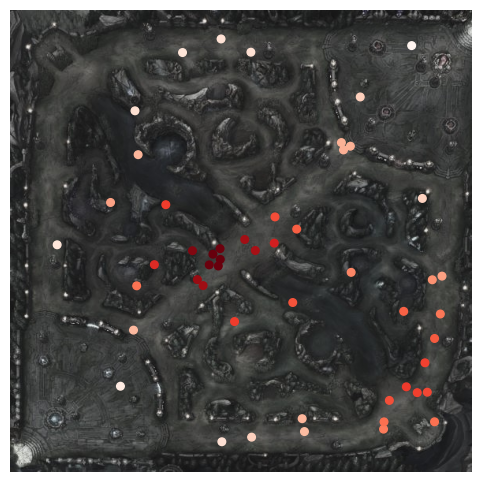

bottom       17
jungle       12
mid          12
top           5
red_zone      4
blue_zone     1
Name: lane, dtype: int64

In [ ]:
death_spot(wak_death_solo[wak_death_solo['timestamp'] >= 15])

wak_death_solo[wak_death_solo['timestamp'] >= 15]['lane'].value_counts()

In [ ]:
wak_death_solo['group'] = 1
wak_death_solo.loc[wak_death_solo['timestamp'] >= 15, 'group'] = 2


<ipython-input-156-db4382886423>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wak_death_solo['group'] = 1


In [ ]:
wak_death_solo['group'].value_counts()

2    51
1    42
Name: group, dtype: int64

damm.. ÎùºÏù∏Ï†Ñ Ïù¥ÌõÑÏóê ÏûòÎ¶¨Îäî Í≤ΩÏö∞Í∞Ä ÏõîÎì±Ìûà ÎçîÎßéÎã§

* Í∑∏Î†áÎã§Î©¥ ÎùºÏù∏Ï†Ñ Ïù¥ÌõÑÏóêÎäî Ï£ºÎ°ú Ïñ¥ÎîîÏÑú ÏûòÎ¶¨Îäî Í±∏Íπå?

In [ ]:
# ÎùºÏù∏ÏùÑ Î®∏Î¨∏ Ï†êÏàò Í≥ÑÏÇ∞
def calculate_lane(x, y):
    top_ranges = [(500, 2000, 6000, 14000),(600, 9000, 13000, 14500), (1900,4500,11100,13100)]

    bottom_ranges = [(6000, 14000, 500, 2000),(13000,14500, 500,9000),(10500,13000,2000,3800)]

    mid_ranges = [(4500, 6000, 4500, 6000),(5200,6700,5200,6700),(5900,7400,5900,7400),(6000,8500,6000,8500),
                  (7300,8800,7300,8800),(8000,9500,8000,9500),(8700,10200,8700,10200),(9200,10500,9200,10500)]

    blue_zone = [(0,4500,0,4500)]
    red_zone = [(10500,15000,10500,15000)]

    for range_ in top_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'top'
    for range_ in mid_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'mid'
    for range_ in bottom_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'bottom'
    for range_ in blue_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'blue_zone'
    for range_ in red_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'red_zone'
    return 'jungle' # ÎÇòÎ®∏ÏßÄÎäî jungle


In [ ]:
wak_death_log.loc[:, 'lane'] = wak_death_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)
wak_death_log

* Ï¢åÌëúÎ•º Î®ºÏ†Ä ÏãúÍ∞ÅÌôîÌï¥Î≥¥Ïûê
* ÏïÑÎûòÎäî 15Î∂Ñ Ïù¥ÌõÑ ÏÜîÎ°úÌÇ¨Î°ú ÏûòÎ¶∞ Í≤ΩÏö∞Ïù¥Îã§.
> ÌäπÌûà, Î∞îÌÖÄÎùºÏù∏ÏóêÏÑú Ïß§Î¶¨Îäî Í≤ΩÏö∞Í∞Ä ÎßéÏùÄÍ≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§. ÏïÑÎ¨¥ÎûòÎèÑ ÎùºÏù∏Ï†Ñ(ÎØ∏Îìú) Ïù¥ÌõÑ Î∞îÌÖÄÎùºÏù∏Í≥º Ïä§ÏôëÌïòÍ≥† ÏÇ¨Ïù¥ÎìúÎ•º ÎØ∏Îäî Í≤ΩÏö∞Í∞Ä ÎßéÏùÄÎç∞, Ïù¥ Îïå ÌëúÏ†ÅÏù¥ ÎêòÍ∏∞ ÏâΩÎã§.

In [ ]:
df = wak_death_solo[wak_death_solo['group'] == 2]

In [ ]:
df['lane'].value_counts()

bottom       20
jungle       13
mid           7
blue_zone     5
top           4
red_zone      2
Name: lane, dtype: int64

In [ ]:
# ÏÉÅÎåÄÏ†ïÍ∏ÄÎ°ú Ïù∏Ìïú Îç∞Ïä§
jungle_death_15 = jungle_death[jungle_death['timestamp'] < 16]
jungle_death_16 = jungle_death[jungle_death['timestamp'] > 15]
jungle_death_15.loc[:, 'lane'] = jungle_death_15.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)


<ipython-input-168-eea9d5a0b9f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jungle_death_15.loc[:, 'lane'] = jungle_death_15.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)


In [ ]:
jungle_death_15['lane'].value_counts()

jungle    95
bottom    79
top       46
mid       40
Name: lane, dtype: int64

(15Î∂Ñ Ïù¥ÌõÑ) ÎØ∏ÎìúÎùºÏù¥ÎÑàÏùò Í≤ΩÏö∞ ÎùºÏù∏Ï†ÑÏù¥ ÎÅùÎÇòÍ≥† ÏÇ¨Ïù¥ÎìúÎ•º ÎØ∏Îäî Í≤ΩÏö∞Í∞Ä ÎßéÎã§. Ìï¥Îãπ summoner ÎòêÌïú Î∞îÌÖÄÏù¥ÎÇò Ï†ïÍ∏ÄÏßÄÏó≠ÏóêÏÑú Ïß§Î¶¨Îäî Í≤ΩÏö∞Í∞Ä ÎßéÏùÄÍ≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§.

# ABOUT Ï†ïÍ∏Ä

#### 15Î∂Ñ Ïù¥Ï†Ñ (ÎùºÏù∏Ï†Ñ)
* ÌôïÏã§Ìûà Ï†ïÍ∏ÄÏßÄÏó≠ (Î∞îÎ°†,ÎìúÎûòÍ≥§) ÏóêÏÑú Ïùò Ï†ëÏ†êÏù¥ Í∞ÄÏû• ÎßéÏùå
* ÎùºÏù∏Ï†ÅÏúºÎ°úÎäî Î∞îÌÖÄÏóêÏÑú Í∞ÄÏû• ÎßéÏù¥ Ï†ëÏ†êÏù¥ ÏùºÏñ¥ÎÇ®

Ïù¥ ÎëêÍ∞úÏùò ÏúÑÏπò Î™®Îëê 'ÎØ∏Îìú'Ïùò Ìï©Î•òÍ∞Ä Ïñ¥ÎñªÍ≤åÎ≥¥Î©¥ Ï§ëÏöîÌïú ÏöîÏÜåÏù¥Í∏∞ÎèÑ Ìï©ÎãàÎã§. ÏôúÎÉêÌïòÎ©¥ Î∞îÎ°†, ÎìúÎûòÍ≥§ Î™®Îëê Ïú†Î¶¨ÌïòÍ≤å Í¥ÄÏó¨Ìï† Ïàò ÏûàÎäî ÎùºÏù∏Ïù¥Í∏∞ ÎïåÎ¨∏Ïù¥Ï£†

Í∑∏Î†áÎã§Î©¥ ÌòπÏãú Ìï©Î•òÌïòÎäî Ï∞®Ïù¥Í∞Ä ÏûàÏùÑÍπå?  ÌïòÏßÄÎßå Ïù¥ Ìï©Î•òÏ∞®Ïù¥ÎùºÎäî Í∞ÄÏÑ§ÏùÑ Ï¶ùÎ™ÖÌïòÍ∏∞ ÏúÑÌïú ÏßÄÌëúÍ∞Ä Î≠êÍ∞ÄÏûàÏùÑÍπå?

* Ï†ïÍ∏ÄÏßÄÏó≠ÏóêÏÑú ÏùºÏñ¥ÎÇú death log (ÏÉÅÎåÄ jungle Ïù¥ Î≠çÏùÄ)
* Ìï¥Îãπ death logÏùò ÎîúÍµêÌôò Î°úÍ∑∏


> Ï¢Ä Ïï†Îß§ÌïòÎã§. Ï†ïÍ∏ÄÏùÑ Ï£º Ìè¨ÏßÄÏÖòÏúºÎ°ú ÏÑ†ÌÉùÌïú ÎìÄÏò§Î†•Ïóê Ïì∞ÎäîÍ≤å ÎÇ´Í≤üÎã§.

In [ ]:
wakteam_death_log.loc[:, 'lane'] = wakteam_death_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)

wakteam_death_log[wakteam_death_log['timestamp'] < 16 ]['lane'].value_counts()

bottom    258
jungle    132
top       108
mid       102
Name: lane, dtype: int64

In [ ]:
wakteam_death_log.loc[:, 'lane'] = wakteam_death_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)
all_jungle_death = wakteam_death_log[(wakteam_death_log['timestamp']<16) & (wakteam_death_log['lane']== 'jungle')]



In [ ]:
#  ÎùºÏù∏Ï†ÑÎèôÏïà ÏÉÅÎåÄÏ†ïÍ∏ÄÏùò assist,kill Ïù¥ Îì§Ïñ¥Í∞Ñ data
# Í∑∏Ï§ë Ï†ïÍ∏ÄÏßÄÏó≠ÏóêÏÑú ÏùºÏñ¥ÎÇú logÎßå Í∞ÄÏ†∏Ïò®Îã§.
# Í∑∏Î¶¨Í≥† Ìï©Î•ò Ïó¨Î∂ÄÎ•º Î≥¥Í∏∞ÏúÑÌï¥ÏÑú assit Í∞Ä ÏóÜÎäî Í≤ΩÏö∞Îäî Ï†úÏô∏

jungle_zone_death = jungle_death_15[(jungle_death_15['lane'] == 'jungle') & (jungle_death_15['assistingParticipantIds'].notna() )]
jungle_zone_death.head()

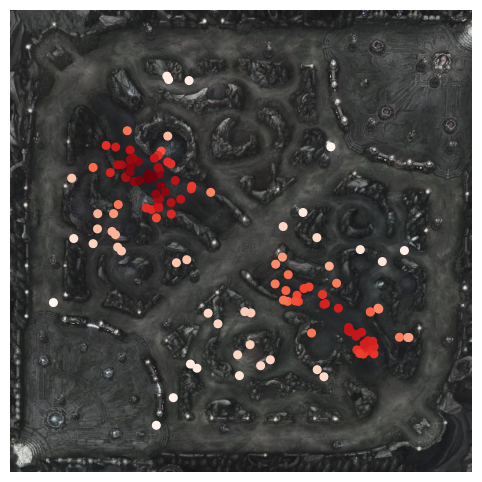

[JUNGLE]                          21
[MIDDLE]                          15
[TOP, JUNGLE]                      9
[UTILITY]                          9
[TOP]                              9
[TOP, MIDDLE]                      7
[BOTTOM]                           7
[JUNGLE, MIDDLE]                   6
[JUNGLE, UTILITY]                  5
[JUNGLE, BOTTOM, UTILITY]          2
[MIDDLE, BOTTOM]                   2
[BOTTOM, UTILITY]                  2
[TOP, BOTTOM, UTILITY]             2
[MIDDLE, UTILITY]                  2
[JUNGLE, BOTTOM]                   2
[TOP, UTILITY]                     1
[BOTTOM, TOP, UTILITY]             1
[TOP, BOTTOM]                      1
[JUNGLE, MIDDLE, BOTTOM]           1
[TOP, JUNGLE, MIDDLE, UTILITY]     1
Name: assistingParticipantIds, dtype: int64

In [ ]:
death_spot(all_jungle_death)
all_jungle_death['assistingParticipantIds'].value_counts()

In [ ]:
# death_spot(jungle_zone_death)
# victimDamageDealt (Ï£ΩÍ∏∞Ï†Ñ Îîú) Í≥º victimDamageReceived (Î∞õÏùÄ ÌîºÌï¥Îüâ) ÏùÑ ÎπÑÍµêÌï¥ÏÑú Ìï©Î•òÏ∞®Ïù¥Î•º Ïñ¥ÎäêÏ†ïÎèÑ Ïú†Ï∂îÌï† Ïàò ÏûàÎã§!!

killer_dealt =  received_damage(jungle_death_15,'victimDamageReceived','killerPosition') # killer Í∞Ä Í∞ÄÌïú ÌîºÌï¥Îüâ = vicitmÏù¥ Î∞õÏùÄ ÌîºÌï¥Îüâ
vicitim_dealt = received_damage(jungle_death_15,'victimDamageDealt','victimPosition') # vicitm Ïù¥ Í∞ÄÌïú ÌîºÌï¥Îüâ = killer Í∞Ä Î∞õÏùÄ ÌîºÌï¥Îüâ

vicitim_dealt.head()

matchId  timestamp      name victimPosition  participantId  \
0  KR_6915832445          7  Pantheon         MIDDLE              2   
1  KR_6915832445          7  Pantheon         MIDDLE              2   
2  KR_6915832445          7  Pantheon         MIDDLE              4   
3  KR_6915832445          7  Pantheon         MIDDLE              4   
0  KR_6915767550          6     Leona        UTILITY              2   

           spellName  magicDamage  physicalDamage  trueDamage  totalDamage  
0        summonerdot            0               0          68           68  
1          pantheonq            0             109           0          109  
2          pantheonw            0              45           0           45  
3          pantheonq            0             115           0          115  
0  leonasolarbarrier           15               0           0           15

In [ ]:
# Îç∞ÎØ∏ÏßÄÎ°ú ÏßëÍ≥Ñ
# ÏÉÅÎåÄ Ï†ïÍ∏ÄÍ≥º ÏÉÅÎåÄ Ìè¨ÏßÄÏÖòÏùò Ìï©Î•ò
assit_deal= killer_dealt.groupby(['killerPosition']).agg(
    damage_by = pd.NamedAgg(column = 'totalDamage', aggfunc='count')
)
assit_deal

damage_by
killerPosition           
BOTTOM                361
JUNGLE               1294
MIDDLE                512
TOP                   314
UTILITY               216

In [ ]:
# Îç∞ÎØ∏ÏßÄ, Ïä§ÌÇ¨ÏÉ∑ Ïπ¥Ïö¥Ìä∏
# Ïö∞Î¶¨ÌåÄ Ìï©Î•ò
vicitm_deal= vicitim_dealt.groupby(['victimPosition']).agg(
    damage_by = pd.NamedAgg(column = 'totalDamage', aggfunc='count')
)

vicitm_deal

damage_by
victimPosition           
BOTTOM                177
JUNGLE                383
MIDDLE                222
TOP                   266
UTILITY               197

## Ïö∞Î¶¨ÌåÄ Ï†ïÍ∏ÄÏù¥ ÌÇ¨ÌïòÎäî Í≤ΩÏö∞?


In [ ]:
# team_info
team_info.columns =['matchId',	'teamId',	'killerId','summonerName','killerPosition','championName','win'] # Ïö∞Î¶¨ÌåÄ ÌÇ¨

In [ ]:
wakteam_kill_log = pd.merge(kill_log, team_info, on=['matchId', 'killerId'], how='inner')

def replace_ids_with_names(ids ,match_id):

    if isinstance(ids, list):
        return [team_info.loc[(team_info['killerId'] == id) & (team_info['matchId'] == match_id), 'summonerName'].values[0] if pd.notna(id) else None for id in ids]
    else:
        return None

wakteam_kill_log['assistingParticipantIds'] = wakteam_kill_log.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)

In [ ]:
# oppnent_info = team_info.copy()
# oppnent_info.columns = ['matchId', 'teamId','vicitmId','summonerName','championName','killerPosition','win']



In [ ]:
wakteam_kill_log.loc[:, 'lane'] = wakteam_kill_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)


In [ ]:
# Ïö∞Î¶¨ÌåÄÏù¥ Ï†ïÍ∏ÄÎùºÏù∏ÏóêÏÑú ÌÇ¨ÌïòÎäî Í≤ΩÏö∞
all_kill_log_15 = wakteam_kill_log[(wakteam_kill_log['timestamp'] < 16) & (wakteam_kill_log['lane']=='jungle') & (wakteam_kill_log['assistingParticipantIds'].notna())]
all_kill_log_15['assistingParticipantIds'].value_counts()

# death_spot(all_kill_log_15)


[JUNGLE]                     17
[MIDDLE]                     12
[BOTTOM, UTILITY]            11
[JUNGLE, UTILITY]            10
[UTILITY]                     7
[MIDDLE, UTILITY]             7
[JUNGLE, MIDDLE]              4
[JUNGLE, MIDDLE, UTILITY]     3
[TOP]                         2
[JUNGLE, BOTTOM]              2
[MIDDLE, BOTTOM, UTILITY]     2
[TOP, MIDDLE, UTILITY]        1
[JUNGLE, BOTTOM, UTILITY]     1
[BOTTOM]                      1
[TOP, MIDDLE]                 1
[TOP, JUNGLE]                 1
[MIDDLE, BOTTOM]              1
[TOP, JUNGLE, BOTTOM]         1
Name: assistingParticipantIds, dtype: int64

#### Î∞îÌÖÄÌïôÏÇ¥Ïûê

In [ ]:
team_info

matchId  teamId  killerId summonerName killerPosition championName  \
5    KR_6923804876     200         6   The Nollan            TOP       Singed   
6    KR_6923804876     200         7          ÏïÑÎ∂àÌé∏         JUNGLE        Poppy   
7    KR_6923804876     200         8          ÏÉÅÍ∏∏Ïß±         MIDDLE        Yasuo   
8    KR_6923804876     200         9      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥         BOTTOM       Lucian   
9    KR_6923804876     200        10      Í¥ëÏïàÎ¶¨ Ìï¥ÌååÎ¶¨        UTILITY         Zyra   
..             ...     ...       ...          ...            ...          ...   
240  KR_6909535501     100         1     hinghong            TOP     Volibear   
241  KR_6909535501     100         2          ÎèàÍπåÏä§         JUNGLE       Rengar   
242  KR_6909535501     100         3      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥         MIDDLE          Zed   
243  KR_6909535501     100         4      Í±∏ÌîÑÎ†åÎìúÏ∞æÏïÑÏöî         BOTTOM       Lucian   
244  KR_6909535501     100         5          Î≤ÑÎÉÑÏ¶à        UTILITY        Swain   

       win  
5     True  
6     True  
7     True  
8     True  
9     True  
..     ...  
240  False  
241  False  
242  False  
243  False  
244  False  

[125 rows x 7 columns]

In [ ]:
wak_kill_log = wakteam_kill_log[wakteam_kill_log['summonerName'] == summoner_name]# |  (wakteam_kill_log['assistingParticipantIds'].apply(lambda x: summoner_name in x if isinstance(x, list) else False))]


In [ ]:
kill_damage = damage(wak_kill_log)
kill_damage

matchId  timestamp championName  killerId  totalDamage  victimId
0   KR_6923804876   0.853450       Singed         6           86       5.0
1   KR_6923804876   0.853450       Singed         6           53       5.0
2   KR_6923804876   0.853450         Zyra        10           54       5.0
3   KR_6923804876   0.853450         Zyra        10           41       5.0
4   KR_6923804876   0.853450         Zyra        10           44       5.0
..            ...        ...          ...       ...          ...       ...
7   KR_6909535501  18.919783          Zed         3          127       7.0
8   KR_6909535501  18.919783          Zed         3           80       7.0
9   KR_6909535501  18.919783          Zed         3          101       7.0
10  KR_6909535501  18.919783          Zed         3          121       7.0
11  KR_6909535501  18.919783          Zed         3          397       7.0

[1986 rows x 6 columns]

In [ ]:
opponent_info = remaining_data[['matchId','teamId','killerId','killerPosition']]
opponent_info.columns=['matchId','teamId','victimId','vicitmPosition']


wak_dmg_merged = pd.merge(kill_damage, opponent_info, on=['matchId', 'victimId'], how='inner')
wak_dmg_merged = pd.merge(wak_dmg_merged, team_info[['matchId','killerId','summonerName']], on=['matchId', 'killerId'], how='inner' )

wak_dmg_merged

matchId  timestamp championName  killerId  totalDamage  victimId  \
0     KR_6923804876   0.853450       Singed         6           86       5.0   
1     KR_6923804876   0.853450       Singed         6           53       5.0   
2     KR_6923804876  26.545283       Singed         6          142       5.0   
3     KR_6923804876  26.545283       Singed         6          557       5.0   
4     KR_6923804876  26.545283       Singed         6           66       5.0   
...             ...        ...          ...       ...          ...       ...   
1777  KR_6909535501  18.919783        Swain         5          202       7.0   
1778  KR_6909535501  18.919783        Swain         5          116       7.0   
1779  KR_6909535501  18.919783        Swain         5          189       7.0   
1780  KR_6909535501  18.919783        Swain         5           36       7.0   
1781  KR_6909535501  18.919783        Swain         5          217       7.0   

      teamId vicitmPosition summonerName  
0        100        UTILITY   The Nollan  
1        100        UTILITY   The Nollan  
2        100        UTILITY   The Nollan  
3        100        UTILITY   The Nollan  
4        100        UTILITY   The Nollan  
...      ...            ...          ...  
1777     200         JUNGLE          Î≤ÑÎÉÑÏ¶à  
1778     200         JUNGLE          Î≤ÑÎÉÑÏ¶à  
1779     200         JUNGLE          Î≤ÑÎÉÑÏ¶à  
1780     200         JUNGLE          Î≤ÑÎÉÑÏ¶à  
1781     200         JUNGLE          Î≤ÑÎÉÑÏ¶à  

[1782 rows x 9 columns]

In [ ]:
# Î∞îÌÖÄÎùºÏù∏ÏùÑ Ï£ΩÏù∏ Î°úÍ∑∏
wak_dmg_merged[wak_dmg_merged['vicitmPosition'].isin(['BOTTOM','UTILITY']) & (wak_dmg_merged['summonerName']== summoner_name)]



matchId  timestamp championName  killerId  totalDamage  victimId  \
23    KR_6923804876    0.85345       Lucian         9           31       5.0   
24    KR_6923804876    0.85345       Lucian         9           33       5.0   
25    KR_6923804876    0.85345       Lucian         9           58       5.0   
26    KR_6923804876    0.85345       Lucian         9           20       5.0   
27    KR_6923804876    0.85345       Lucian         9           81       5.0   
...             ...        ...          ...       ...          ...       ...   
1591  KR_6909622124   29.09145      Caitlyn         4          129      10.0   
1592  KR_6909622124   29.09145      Caitlyn         4           60      10.0   
1593  KR_6909622124   29.09145      Caitlyn         4         1602      10.0   
1594  KR_6909622124   29.09145      Caitlyn         4          166      10.0   
1595  KR_6909622124   29.09145      Caitlyn         4          331      10.0   

      teamId vicitmPosition summonerName  
23       100        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  
24       100        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  
25       100        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  
26       100        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  
27       100        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  
...      ...            ...          ...  
1591     200        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  
1592     200        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  
1593     200        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  
1594     200        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  
1595     200        UTILITY      Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥  

[375 rows x 9 columns]

In [ ]:
match_info = match_info[(match_info['timePlayed'] >= 1200) & (match_info['timePlayed'] < 2500)]
champ_dealt = match_info[match_info['puuid'] == puuid][['championName','totalDamageDealtToChampions','damagePerMinute']]

champ_dealt.groupby(['championName']).agg({'totalDamageDealtToChampions':'mean'})

championName  totalDamageDealtToChampions  damagePerMinute
8         Lucian                        20064       513.509357
17           Zoe                        14543       466.176263
22         Diana                        35678       892.324874
37           Zed                        24725       695.278807
47           Zed                        18665       556.000466
52         Diana                        20692       748.124545
87         Diana                        29765      1053.761305
93       Caitlyn                        18755       765.931627
107         Azir                        26469       878.421701
122        Akali                        24584       764.536701
138      Caitlyn                        15154       567.477848
147          Zed                        18433       719.418855
152         Ahri                        37646      1187.874553
168       Ezreal                        23349       782.899148
178        Kaisa                        42729      1103.337160
182        Akali                        37351      1024.095004
192          Zoe                        36653       994.569978
202          Zoe                        18258       671.256491
218         Ashe                        12597       457.720100
228       Ezreal                        13901       481.241641
233      Caitlyn                        43743      1188.568138
242          Zed                        18844       647.756463

# üíª Í∂ÅÍ∏àÌïúÍ≤å Î≠òÍπå..?
Ï±îÌîºÏñ∏Î≥ÑÎ°ú Î¥êÏïºÌï†Íπå.. Ìè¨ÏßÄÏÖòÎ≥ÑÎ°ú Î¥êÏïºÌï†Íπå.. ÎëòÎã§Î≥¥Ïûê! \

Ïö∞ÏôÅÍµ≥ vs Ïó¨ÌÉúÍπåÏßÄ ÎßåÎÇú ÎØ∏ÎìúÎùºÏù¥ÎÑà

## ‚úîÔ∏è Ìï¥Îãπ summonerÏóê ÎåÄÌïú Î∂ÑÏÑù
### ‚ë† Ïó¨ÌÉúÍπåÏßÄ ÎßåÎÇú Ïú†Ï†ÄÎì§Í≥ºÏùò Í∏∞Î≥∏Ï†ÅÏù∏ ÏßÄÌëúÎπÑÍµê
* ÏÉÅÎåÄÎùºÏù¥ÎÑàÏôÄ ÎπÑÍµê
* ÌåÄÏõêÌèâÍ∑†Í≥º ÎπÑÍµê
* ÏÉÅÎåÄÌèâÍ∑†Í≥º ÎπÑÍµê

### ‚ë° Ïôú Ï£ΩÏùÄ Í±∏Í∞Ä? death ÏôÄ Í¥ÄÎ†®Îêú ÏßÄÌëú
* ÎùºÏù∏Ï†Ñ ÎèôÏïà Ï£ΩÏùÄ Í≤ΩÏö∞, Í∞ÄÏû• Í∞úÏûÖÏù¥ ÎßéÏïòÎçò ÏÉÅÎåÄ Ìè¨ÏßÄÏÖòÏùÄ ÎàÑÍµ¨ÏùºÍπå?
* (ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïúÍ≤ΩÏö∞) ÎùºÏù∏Ï†Ñ Ïù¥ÌõÑ ÎÇòÎäî Ïñ¥ÎîîÏÑú Ïß§Î¶¨Îäî Í±∏Íπå?

### ‚ë¢ Ïôú ÏßÑÍ±∏Íπå? (Î∂ÄÏ†ú: ÎàÑÍ∞Ä Ï£ÑÏù∏Ïù∏Í∞Ä )
* ÎßåÏïΩ Ï°åÎã§Î©¥ Ïñ¥ÎäêÎùºÏù∏Ïù¥ ÌÑ∞Ï†∏ÏÑú ÏßÑÍ±∏Íπå?
* Ï¥àÎ∞òÍ≥º ÌõÑÎ∞òÏúºÎ°ú ÎÇòÎà†ÏÑú Î∂ÑÏÑùÌï† Ïàò ÏûàÏùå
* ÎåÄÌëúÏ†ÅÏù∏ ÏßÄÌëúÎ°ú death Î°úÍ∑∏ÏôÄ gold Ï∞®Ïù¥Î•º Î∂ÑÏÑùÌïòÎ©¥ Îê†Í≤ÉÍ∞ôÎã§
* Ï§ëÍ∞ÑÏóê Í≤åÏûÑÏùÑ Ìè¨Í∏∞ÌïòÍ≥† ÎÇòÍ∞Ñ Í≤ΩÏö∞ÎèÑ ÏûàÏùå  (Ïù¥ Í≤ΩÏö∞ ÌÉàÏ£ºÌïú ÌåÄÏõêÏùÑ ÎßåÎÇú ÌöüÏàòÎ•º Ï∂îÍ∞Ä)


> Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ÏóêÏÑú Í∞Å Îß§ÏπòÎ≥ÑÎ°ú 15Î∂ÑÏ†ÑÌõÑ ÏùºÏñ¥ÎÇú Îç∞Ïä§Î°úÍ∑∏ÏôÄ Í∑∏Ïóê Îî∞Î•∏ Í≥®ÎìúÏ∞®Ïù¥Í∞Ä Ïñ¥ÎäêÏ†ïÎèÑ ÎÇòÌÉÄÎÇòÎäîÏßÄ, Í∑∏ÎûòÏÑú Ïñ¥Îñ§ ÎùºÏù∏Ïóê ÏùòÌï¥ Í≤åÏûÑÏù¥ ÌÑ∞Ï°åÎäîÏßÄ ÌôïÏù∏Ìï¥Î≥º Ïàò ÏûàÎã§!

### ‚ë£ ÌòÑÏû¨ÍπåÏßÄ Ìï©Ïù¥ ÏûòÎßûÎäî ÎìÄÏò§Îäî ÎàÑÍµ¨ÏùºÍπå?
> Ìï©Ïù¥ ÏûòÎßûÎã§Îäî Í∏∞Ï§ÄÏùÑ Î¨¥ÏóáÏúºÎ°ú Î≥ºÍ≤ÉÏù∏Í∞Ä
* Í∏∞Î≥∏Ï†ÅÏù∏ ÏßÄÌëú, ÎùºÏù∏Ï†Ñ Ï∫êÎ¶¨Î†•, ÌïúÌÉÄ Ï∫êÎ¶¨Î†•, ÌòÑÏû¨ÍπåÏßÄÏùò ÏäπÎ•†
* summoner ÏôÄ ÏÉÅÌò∏ÏûëÏö©ÏùÑ ÌÜµÌï¥ Í∞ÄÏû• ÎßéÏùÄ kill,assist ÏÑ±Í≥ºÎ•º Îã¨ÏÑ±Ìïú Î©§Î≤Ñ?

---

## üìä ÎåÄÏãúÎ≥¥Îìú Íµ¨ÏÑ±

>  ### summoner_INFO
*  summonerICON, summonerName, Rank, ÏäπÎ•†, mostChamp,

> ### Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ Î∂ÑÏÑù
*  ÎàÑÍ∞Ä Ï£ÑÏù∏Ïù∏Í∞Ä? ÏµúÍ∑º 50Í≤ΩÍ∏∞Ï§ë Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Î•º Í∏∞Ï§Ä, 15Î∂Ñ Ï†ÑÌõÑÎ°ú Ìè¨ÏßÄÏÖòÎ≥Ñ Í≥®ÎìúÏ∞®Ïù¥Î•º ÏãúÍ∞ÅÌôî
* DEATH position : ÎùºÏù∏Ï†Ñ Ïù¥ÌõÑ SOLO KILLÏùÑ Í∞ÄÏû• ÎßéÏù¥ ÎãπÌïú Í≥≥ (Ïß§Î¶∞Í≥≥)
*

> ### ÎìÄÏò§ Ï∏°Ï†ïÍ∏∞
*


In [ ]:
match_info.head(10)

teamId                                              puuid   summonerName  \
0     100  fHWB3mif-L5EVhN7LsbfHq2Ydma2E-de-GlwpMGayPCGsX...  dfjkgbkbdfs77   
1     100  SJ45Oocwzn389g6QY2eLcJzzVAtlfAfelvoJtTncr_rA6e...     The Nollan   
2     100  ELaIdl9QqdjENlnKDGbAmYAVxyYAZdcBtIV36Ymwlfkr3W...        Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥   
3     100  TMRpbFIR4aP_kZVrfDIRY6XRUt9D3xr2vBhSdzpRE_MtK9...         Í∞úsiÎ∞úÎÜàÎì§   
4     100  426gqu0wDVe8ChV4K9yP7T8EIimWAvZ1HJPpH0rqJgIMlw...         ÎπµÏ¢ÄÏÇ¨Ï£ºÏÑ∏Ïöî   
5     200  y2Re1-BfwCu70OSYBhOe9Oaw9lUKpjgzJJWdPg-p5e1V6O...         ÏòÅÌôòÏù¥ÏÇ¨ÎÉ•Íæº   
6     200  4EdsfjfUbFzv7KYbdfgKaWAIQFt0WKT2TopqRkP_yoz_8Q...       ÏöîÎ¶≠Ï°∞ÏßÄÍ∏∞Í≥ºÍµêÏàò   
7     200  kLLmc3eLUlo6Ci-GQtqlrdDQdSr2amsKaM4PnFoLbZ7uda...  Sumerian King   
8     200  wnUWBRBfcEfOQ_1Gvkw0Qx7yW7vS6jmCrxeEHUX8di8rMH...            Îö±Î∞∞ÏÉ∑   
9     200  5a7rP_OkWYOJCsq_OXWyJYc9RCQoS_dd8zcXhPC3gemQwJ...         ÏÜúÏÇ¨ÌÉïÎßõÎπÑÏàë   

   participantId teamPosition  \
0              1          TOP   
1              2       JUNGLE   
2              3       MIDDLE   
3              4       BOTTOM   
4              5      UTILITY   
5              6          TOP   
6              7       JUNGLE   
7              8       MIDDLE   
8              9       BOTTOM   
9             10      UTILITY   

                                          challenges  summoner1Id  \
0  {'12AssistStreakCount': 0, 'abilityUses': 297,...           14   
1  {'12AssistStreakCount': 0, 'abilityUses': 426,...           11   
2  {'12AssistStreakCount': 0, 'abilityUses': 505,...            4   
3  {'12AssistStreakCount': 0, 'abilityUses': 354,...           14   
4  {'12AssistStreakCount': 0, 'abilityUses': 152,...            4   
5  {'12AssistStreakCount': 1, 'abilityUses': 135,...            6   
6  {'12AssistStreakCount': 0, 'abilityUses': 426,...           11   
7  {'12AssistStreakCount': 0, 'abilityUses': 449,...           14   
8  {'12AssistStreakCount': 0, 'abilityUses': 509,...            4   
9  {'12AssistStreakCount': 0, 'abilityUses': 189,...            4   

   summoner2Id championName    lane  kills  deaths  assists  \
0            4        Teemo  JUNGLE      5      12        3   
1            4     JarvanIV  JUNGLE      8       6        8   
2           14          Zoe  MIDDLE      2      10        5   
3            4       Lucian  BOTTOM      3       3        3   
4            7        Brand  BOTTOM      4       7        4   
5           12       Thresh     TOP      3       2       14   
6            4       Yorick  JUNGLE      9       4        9   
7            4         Fizz  MIDDLE     23       4        3   
8            7       Ezreal  BOTTOM      1       6        8   
9            3      Morgana  BOTTOM      2       6       14   

   totalMinionsKilled  neutralMinionsKilled  goldEarned  goldSpent  \
0                 230                    31       17239      17100   
1                 107                   176       18139      17250   
2                 187                     0       12697      11850   
3                 388                    24       20012      25410   
4                  59                     0       12522      11875   
5                 171                     0       13165      11925   
6                 201                   167       22190      20183   
7                 301                    22       24729      24330   
8                 313                     8       15794      13808   
9                  73                     0       13726      11625   

   champExperience  item0  item1  item2  item3  item4  item5  item6  \
0            22882   3089   6653   3020   3118   4646   4645   3340   
1            21262   3161   6333   3071   3156   6610   3111   3364   
2            18981   6655   4646   3020   4645   2022   1026   3340   
3            21301   6675   3095   3094   6672   3036   3158   3363   
4            14810   3871   6653   2421   3020   3118   3165   3364   
5            21858   1029   3068   307

In [ ]:
# Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ Í∏∞Ï§Ä

champion_info = match_info[['matchId','teamId','participantId','summonerName','teamPosition','championName','win']]
# len(champion_info[(champion_info['summonerName'] == summoner_name) & (champion_info['teamPosition'] == 'MIDDLE')]) # ÎØ∏ÎìúÎùºÏù¥ÎÑàÎ°ú Í∞Ñ Í≤ΩÍ∏∞ 42Í∞ú (49Í≤ΩÍ∏∞Ï§ë)
# champion_info

42

In [ ]:
# Îß§ÏπòÏïÑÏù¥ÎîîÎ≥Ñ Í∞ôÏùÄÌåÄÏõêÎì§Ïùò victimId Ïóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞Îßå Í∞ÄÏ†∏Ïò®Îã§.
# Í∞Å victimId Ïóê Ìï¥ÎãπÌïòÎäî participantId , Ìè¨ÏßÄÏÖò, Í≤∞Ìï©
champion_info['summonerName'] = champion_info.apply(lambda row: row['championName'][:3] if row['summonerName'].strip() == '' else row['summonerName'], axis=1)
champion_info.columns=['matchId','teamId','victimId','summonerName','teamPosition','championName','win']


In [ ]:
champion_info

In [ ]:
# Îß§ÏπòÏïÑÏù¥ÎîîÎ≥ÑÎ°ú Î≥∏Ïù∏ ÌåÄÏóê ÏÜçÌïú teamId
wak_team = champion_info.loc[(champion_info['summonerName'] == summoner_name), ['matchId','teamId']]

# ÏôÅÍµ≥ÌåÄÎßå Í∞ÄÏ†∏Ïò§Í∏∞
wak_team = pd.merge(wak_team, champion_info, on=['matchId', 'teamId'], how='inner')


In [ ]:
# Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Îäî 26Í≤ΩÍ∏∞ (49)
# Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Ïùò champion_INFO
wak_team_lose = wak_team[wak_team['win'] == 'Ìå®Î∞∞']
wak_team_lose

In [ ]:
# ÌåÄÏõêÎì§Ïùò Îç∞Ïä§Î°úÍ∑∏
all_death_log = pd.merge(kill_log, wak_team_lose, on=['matchId', 'victimId'], how='inner')

In [ ]:
all_death_log.head()

timestamp           type                 position  teamId_x  killerId  \
0   2.900233  CHAMPION_KILL  {'x': 12130, 'y': 2201}       NaN       4.0   
1   7.428850  CHAMPION_KILL  {'x': 13544, 'y': 3644}       NaN       4.0   
2  15.471183  CHAMPION_KILL  {'x': 12249, 'y': 2199}       NaN       5.0   
3  17.561667  CHAMPION_KILL  {'x': 11230, 'y': 3804}       NaN       2.0   
4  18.573967  CHAMPION_KILL  {'x': 13539, 'y': 6399}       NaN       3.0   

   victimId assistingParticipantIds  \
0      10.0                     [5]   
1      10.0                     [5]   
2      10.0                     [4]   
3      10.0                     NaN   
4      10.0                     [5]   

                                   victimDamageDealt  \
0  [{'basic': False, 'magicDamage': 66, 'name': '...   
1  [{'basic': False, 'magicDamage': 65, 'name': '...   
2  [{'basic': False, 'magicDamage': 184, 'name': ...   
3                                                NaN   
4  [{'basic': False, 'magicDamage': 134, 'name': ...   

                                victimDamageReceived        matchId  teamId_y  \
0  [{'basic': False, 'magicDamage': 175, 'name': ...  KR_6884575817       200   
1  [{'basic': False, 'magicDamage': 278, 'name': ...  KR_6884575817       200   
2  [{'basic': True, 'magicDamage': 0, 'name': 'Mi...  KR_6884575817       200   
3  [{'basic': False, 'magicDamage': 0, 'name': 'K...  KR_6884575817       200   
4  [{'basic': True, 'magicDamage': 0, 'name': 'Ne...  KR_6884575817       200   

  summonerName teamPosition championName win  
0      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞  
1      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞  
2      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞  
3      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞  
4      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞

In [ ]:
# ÌåÄÏõêÎì§Ïùò Îç∞Ïä§ Î°úÍ∑∏
position_by_death = all_death_log[all_death_log['timestamp'] < 15].groupby(['teamPosition']).agg({'type':'count'}).reset_index()
position_by_death

teamPosition  type
0       BOTTOM    63
1       JUNGLE    65
2       MIDDLE    59
3          TOP    80
4      UTILITY    65

In [ ]:
# ÌåÄÏõêÎì§Ïùò ÌÇ¨ Î°úÍ∑∏
wak_team_lose.columns = ['matchId',	'teamId',	'killerId','summonerName', 'teamPosition',	'championName',	'win']
all_kill_log = pd.merge(kill_log, wak_team_lose, on=['matchId', 'killerId'], how='inner')

position_by_kill = all_kill_log[all_kill_log['timestamp'] < 15].groupby(['teamPosition']).agg({'type':'count'})
position_by_kill

type
teamPosition      
BOTTOM          46
JUNGLE          58
MIDDLE          51
TOP             43
UTILITY         36

In [ ]:
# Îç∞ÎØ∏ÏßÄÎ°ú ÏßëÍ≥Ñ (Î∞õÏùÄÌîºÌï¥Îüâ) - Îç∞Ïä§ Í∏∞Ï§Ä
def received_damage(all_death_log):
  death_list = []
  if not all_death_log.empty:
      for d, ts, id, p in zip(all_death_log['victimDamageReceived'], all_death_log['timestamp'],all_death_log['matchId'],all_death_log['teamPosition']):
          df = pd.json_normalize(d)
          df['timestamp'] = ts
          df['matchId'] = id
          df['teamPosition'] = p
          death_list.append(df)

      death_damage_log = pd.concat(death_list, axis=0)
      death_damage_log = death_damage_log[['matchId','timestamp','name','teamPosition','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
      death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

  else:
      death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','teamPosition','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])

  return death_damage_log





In [ ]:
# Ìè¨ÏßÄÏÖòÎ≥Ñ 15Î∂Ñ Ïù¥Ï†ÑÏóê Î∞õÏùÄ ÌîºÌï¥Îüâ
before_15_death = death_damage_log[death_damage_log['timestamp'] < 15]
damage_by_position = before_15_death.groupby(['matchId','teamPosition']).agg({'totalDamage':'sum'}).sort_values(by=['matchId','totalDamage'], ascending=False)
damage_by_position['rank'] = damage_by_position.groupby('matchId')['totalDamage'].rank(ascending=False, method='min')
damage_by_position

In [ ]:
# Îç∞ÎØ∏ÏßÄÎ°ú ÏßëÍ≥Ñ (Í∞ÄÌïúÌîºÌï¥Îüâ) - ÌÇ¨ Í∏∞Ï§Ä

kill_lists = []
if not all_kill_log.empty:
    for d, ts, id, p in zip(all_kill_log['victimDamageReceived'], all_kill_log['timestamp'],all_kill_log['matchId'],all_kill_log['teamPosition']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        df['teamPosition'] = p
        kill_lists.append(df)

    kill_damage_log = pd.concat(kill_lists, axis=0)
    kill_damage_log = kill_damage_log[['matchId','timestamp','name','teamPosition','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
    kill_damage_log['name'] = kill_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    kill_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','teamPosition','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])


kill_damage_log['totalDamage'] = kill_damage_log['magicDamage'] + kill_damage_log['physicalDamage'] + kill_damage_log['trueDamage']

In [ ]:
# Ìè¨ÏßÄÏÖòÎ≥Ñ 15Î∂Ñ Ïù¥Ï†ÑÏóê Í∞ÄÌïú ÌîºÌï¥Îüâ
before_15_kil = kill_damage_log[kill_damage_log['timestamp'] < 15]
kill_by_position = before_15_kil.groupby(['matchId','teamPosition']).agg({'totalDamage':'sum'}).sort_values(by=['matchId','totalDamage'], ascending=False)
kill_by_position['rank'] = kill_by_position.groupby('matchId')['totalDamage'].rank(ascending=False, method='min')
kill_by_position

In [ ]:
rank1_counts_kill = kill_by_position[kill_by_position['rank'] == 1].groupby('teamPosition').size()
rank1_counts_damage = damage_by_position[damage_by_position['rank'] == 1].groupby('teamPosition').size()

print(rank1_counts_kill)
print(rank1_counts_damage)

teamPosition
BOTTOM     3
JUNGLE     8
MIDDLE     5
TOP        5
UTILITY    5
dtype: int64
teamPosition
BOTTOM      3
JUNGLE      3
MIDDLE      4
TOP        11
UTILITY     5
dtype: int64


* Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ Ï§ë, 15Î∂ÑÏù¥Ï†ÑÏóê Í∞ÄÏû• ÎßéÏùÄ Îç∞ÎØ∏ÏßÄÎ•º Î∞õÍ≥† Ï£ΩÏùÄ Ìè¨ÏßÄÏÖò "TOP"

* Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ Ï§ë, 15Î∂ÑÏù¥Ï†ÑÏóê Í∞ÄÏû• ÎßéÏùÄ Îîú, ÌÇ¨ÏùÑÌïú Ìè¨ÏßÄÏÖòÏùÄ "JUNGLE"

# Í≤ΩÍ∏∞, ÌåÄÎ≥Ñ Í≥®Îìú Î≥ÄÌôîÎüâ

>  Í≤åÏûÑÏù¥ Ïñ¥ÎäêÏàúÍ∞Ñ Î∂ÄÌÑ∞ Î∂àÎ¶¨ÌïòÍ≤å ÎèåÏïÑÍ∞ÄÎäîÏßÄ ÌôïÏù∏Ìï† Ïàò ÏûàÎäî ÎåÄÌëúÏ†ÅÏù∏ ÏßÄÌëúÎ°ú goldÍ∞Ä ÏûàÎã§.  ÏãúÍ∞ÑÎ≥ÑÎ°ú gold Í≤©Ï∞®Í∞Ä ÌÅ¨Í≤å Ï∞®Ïù¥ÎÇòÍ±∞ÎÇò, Ïó≠Ï†ÑÎãπÌïòÎäî ÏãúÏ†êÏù¥ ÏûàÎã§Î©¥ Ïñ¥Îñ§ ÏãúÏ†êÏùºÍπå?

* Í∞Å matchid, teamid, timestamp Î•º groupby Ìï¥ÏïºÌï® ‚úîÔ∏è

> ÎåÄÏãúÎ≥¥ÎìúÎ°ú Ïñ¥ÎñªÍ≤å ÌëúÌòÑÌï† Í≤É Ïù∏Í∞Ä?

* line chart : Î≥∏Ïù∏ + ÌåÄÏõêÌèâÍ∑† + ÏÉÅÎåÄÌåÄÌèâÍ∑†

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
df = pd.concat(match_data_logs)
match_data_log = df[:6]

In [ ]:
# Î™®Îì† match Í∞Ä concat Îêú frames Ï§ë Ï≤´Î≤àÏ®∞ timestamp dataÎ•º Í∞ÄÏ†∏Ïò§Î©¥ ÏïÑÎûòÏôÄ Í∞ôÏùå
log1 = pd.DataFrame(df['info']['frames'][10])
log1

In [ ]:
frames_data = df['info']['frames']
matchId_data= df['metadata']['matchId']

all_data = pd.DataFrame()


# 'frames'Ïùò Í∞Å Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Î∞òÎ≥µ
for i, frame in enumerate(frames_data):
    # ÌòÑÏû¨ ÌîÑÎ†àÏûÑÏùò Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    frame_data = pd.DataFrame(frame)

    # ÌòÑÏû¨ ÌîÑÎ†àÏûÑÏùò Îç∞Ïù¥ÌÑ∞Ïóê matchId Ï∂îÍ∞Ä
    frame_data['matchId'] = matchId_data[i]

    # ÌòÑÏû¨ ÌîÑÎ†àÏûÑÏùò Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê Ï∂îÍ∞Ä
    all_data = pd.concat([all_data, frame_data])

# all_data

In [ ]:
frames_list = pd.DataFrame(all_data['participantFrames'])['participantFrames'].tolist()

In [ ]:
all_data.head(100)

In [ ]:
unique_match_ids = all_data['matchId'].unique()

# Î™®Îì† Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
final_result = []

for match_Id in unique_match_ids:
    # match_IdÏóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú
    match_data = all_data[all_data['matchId'] == match_Id]
    timestamp = match_data['timestamp']

    # participantFrames Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
    frames_list = pd.DataFrame(match_data['participantFrames'])['participantFrames'].tolist()
    participant_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    moving_data = [[] for _ in range(len(participant_ids))]

    for frame in frames_list:
        for i, participant_id in enumerate(participant_ids):
            if str(participant_id) in frame:
                moving_data[i].append(frame[str(participant_id)])

    moving_dfs = [pd.DataFrame(md) for md in moving_data]
    # moving = pd.concat(moving_dfs, ignore_index=True)

    # ÏãúÍ∞Ñ Ï†ïÎ≥¥ , match_Id Ïó¥ Ï∂îÍ∞Ä
    for i, moving_df in enumerate(moving_dfs):
        moving_df['timestamp'] = timestamp / 60000
        moving_df['matchId'] = match_Id

    # Í≤∞Í≥ºÎ•º Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
    final_result.extend(moving_dfs)

# Î™®Îì† Í≤∞Í≥ºÎ•º Ìï©Ï≥êÏÑú ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
final_result_df = pd.concat(final_result, ignore_index=True)


In [ ]:
# GOLD ÏôÄ Í¥ÄÎ†®Îêú Ïª¨Îüº
gold = final_result_df[['matchId','timestamp','participantId','position','totalGold','xp','level']]
# gold.head(100)

In [ ]:
final_result_df.head()

championStats  currentGold  \
0  {'abilityHaste': 0, 'abilityPower': 0, 'armor'...          500   
1  {'abilityHaste': 0, 'abilityPower': 0, 'armor'...            0   
2  {'abilityHaste': 0, 'abilityPower': 0, 'armor'...           84   
3  {'abilityHaste': 0, 'abilityPower': 0, 'armor'...          339   
4  {'abilityHaste': 0, 'abilityPower': 0, 'armor'...          497   

                                         damageStats  goldPerSecond  \
0  {'magicDamageDone': 0, 'magicDamageDoneToChamp...              0   
1  {'magicDamageDone': 0, 'magicDamageDoneToChamp...              0   
2  {'magicDamageDone': 0, 'magicDamageDoneToChamp...              0   
3  {'magicDamageDone': 0, 'magicDamageDoneToChamp...              0   
4  {'magicDamageDone': 791, 'magicDamageDoneToCha...              0   

   jungleMinionsKilled  level  minionsKilled  participantId  \
0                    0      1              0              1   
1                    0      1              0              1   
2                    0      1              3              1   
3                    0      3             11              1   
4                    0      4             13              1   

                  position  timeEnemySpentControlled  totalGold    xp  \
0     {'x': 554, 'y': 581}                         0        500     0   
1  {'x': 12120, 'y': 4647}                         0        500     0   
2  {'x': 2015, 'y': 12324}                      6504        584   185   
3  {'x': 2629, 'y': 13023}                     29651        839   924   
4  {'x': 1584, 'y': 13061}                     67364        997  1416   

   timestamp        matchId  
0   0.000000  KR_6918757013  
1   1.000367  KR_6918757013  
2   2.000633  KR_6918757013  
3   3.000900  KR_6918757013  
4   4.001367  KR_6918757013

In [ ]:
champion_info = champion_info[['matchId','participantId','teamId','teamPosition','summonerName','championName','win']]

In [ ]:
gold_df = pd.merge(gold, champion_info, on=['matchId', 'participantId'], how='inner')
gold_df.head()

matchId  timestamp  participantId                 position  \
0  KR_6905652615   0.000000              1     {'x': 554, 'y': 581}   
1  KR_6905652615   1.000333              1  {'x': 6874, 'y': 11408}   
2  KR_6905652615   2.000900              1  {'x': 1647, 'y': 12285}   
3  KR_6905652615   3.001167              1  {'x': 1633, 'y': 12850}   
4  KR_6905652615   4.001217              1  {'x': 2261, 'y': 11826}   

   totalGold    xp  level  teamId teamPosition summonerName championName  \
0        500     0      1     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   
1        500     0      1     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   
2        563   185      1     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   
3        797   671      3     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   
4       1088  1284      4     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   

     win  
0  False  
1  False  
2  False  
3  False  
4  False

### Ï†ïÍ∏ÄÏùò ÎèôÏÑ†ÏùÑ ÏãúÍ∞ÅÌôîÌï¥Î≥¥Ïûê


In [ ]:
# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ merge

position_df = pd.merge(final_result_df, champion_info, on=['matchId', 'participantId'], how='inner')
position_df = position_df[['matchId','timestamp','participantId','teamId','position','xp','teamPosition','championName']]
position_df['timestamp'] = position_df['timestamp'].astype(int)
position_df.loc[:, 'lane'] = position_df.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)

jungle = position_df[position_df['teamPosition'] == 'JUNGLE']
blue_jungle = jungle[jungle['teamId'] == 100]
red_jungle = jungle[jungle['teamId'] == 200]

<ipython-input-13-b6b38cca6c14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_df['timestamp'] = position_df['timestamp'].astype(int)
<ipython-input-13-b6b38cca6c14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position_df.loc[:, 'lane'] = position_df.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)


In [ ]:
jungle.head(10)

Ïñ¥ÎñªÍ≤å Ïä§ÌÜ†Î¶¨Î•º ÏßúÏïºÌï†Íπå?


In [219]:
import seaborn as sns

def death_spot(df):
    x_data = df['position'].apply(lambda pos: pos['x'])
    y_data = df['position'].apply(lambda pos: pos['y'])

    # Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000)
    plt.axis('off')

    # ÏßÄÎèÑ Ïù¥ÎØ∏ÏßÄ Ï∂îÍ∞Ä
    map_path = "/content/map.jpg"
    img = Image.open(map_path)
    ax.imshow(img, extent=[0, 15000, 0, 15000])

    # SeabornÏùò kdeplotÏúºÎ°ú ÏùåÏòÅ Ï∂îÍ∞Ä
    sns.kdeplot(x=x_data, y=y_data, shade=True, cmap='Purples', ax=ax, alpha=0.2)

    # ÏÇ∞Ï†êÎèÑÎ°ú ÌëúÏãú
    colors = np.where(df['teamId'] == 100, '#459ae5', '#ed4141')
    sc = ax.scatter(x_data, y_data, c=colors, alpha=0.7, s=30, edgecolors='none')

    plt.show()

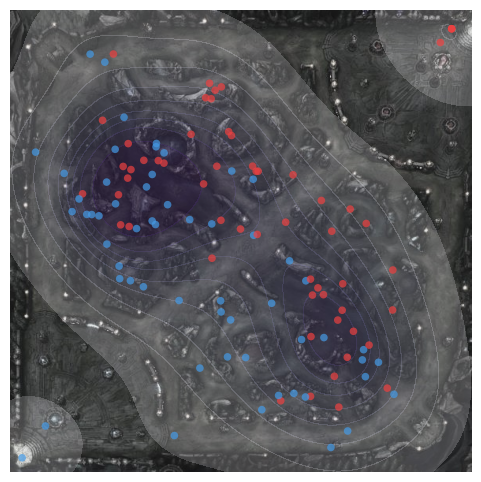

In [244]:
df = jungle[jungle['timestamp'].isin([10,11])]
death_spot(df)

# print(df['lane'].value_counts())
# wak_death_time['lane'].value_counts().plot.bar()

In [ ]:
x_data = jungle['position'].apply(lambda pos: pos['x'])
print(x_data)

<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
<ipython-input-218-28b4ea0073f4>:42: UserWarning: KDE cannot be estimate

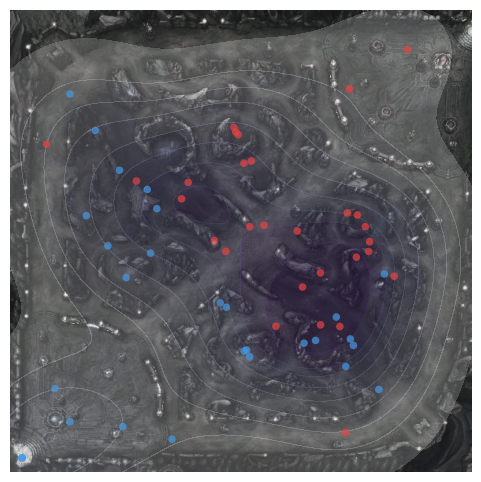

In [218]:
from matplotlib.animation import FuncAnimation

def death_spot2(df):
    x_data = df['position'].apply(lambda pos: pos['x'])
    y_data = df['position'].apply(lambda pos: pos['y'])

    # Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000)
    plt.axis('off')

    # ÏßÄÎèÑ Ïù¥ÎØ∏ÏßÄ Ï∂îÍ∞Ä
    map_path = "/content/map.jpg"
    img = Image.open(map_path)
    ax.imshow(img, extent=[0, 15000, 0, 15000])

    # SeabornÏùò kdeplotÏúºÎ°ú ÏùåÏòÅ Ï∂îÍ∞Ä
    sns.kdeplot(x=x_data, y=y_data, shade=True, cmap='Purples', ax=ax, alpha=0.2)

    # ÏÇ∞Ï†êÎèÑÎ°ú ÌëúÏãú
    colors = np.where(df['teamId'] == 100, '#459ae5', '#ed4141')
    sc = ax.scatter(x_data, y_data, c=colors, alpha=0.7, s=30, edgecolors='none')

    def update(frame):
        timestamp = df['timestamp'].unique()[frame]
        timestamp_df = df[df['timestamp'] == timestamp]

        # Clear previous KDE plot
        ax.clear()

        # Set limits and axis properties
        ax.set_xlim(0, 15000)
        ax.set_ylim(0, 15000)
        plt.axis('off')

        # Add map image
        img = Image.open(map_path)
        ax.imshow(img, extent=[0, 15000, 0, 15000])

        # Plot new KDE plot for the current timestamp
        sns.kdeplot(x=timestamp_df['position'].apply(lambda pos: pos['x']),
                    y=timestamp_df['position'].apply(lambda pos: pos['y']),
                    shade=True, cmap='Purples', ax=ax, alpha=0.2)

        # Update the scatter plot for the current timestamp
        colors = np.where(timestamp_df['teamId'] == 100, '#459ae5', '#ed4141')
        sc = ax.scatter(timestamp_df['position'].apply(lambda pos: pos['x']),
                      timestamp_df['position'].apply(lambda pos: pos['y']),
                      c=colors, alpha=0.7, s=30, edgecolors='none')

        return sc,

    num_frames = 15
    ani = FuncAnimation(fig, update, frames=num_frames, interval=1000, blit=True)

    return ani

ani = death_spot2(jungle)
HTML(ani.to_jshtml())
ani.save('/content/jungle_anime3.gif', writer='imagemagick', dpi=300) # gifÌååÏùºÎ°ú Ï†ÄÏû•


In [ ]:
from IPython.display import HTML
HTML(ani.to_jshtml())



In [ ]:
blue_jungle[blue_jungle['lane'] == 'TOP']

In [ ]:
monster_log = p_df[p_df['type'] == 'ELITE_MONSTER_KILL']
monster_log['timestamp'] = monster_log['timestamp'] / 60000


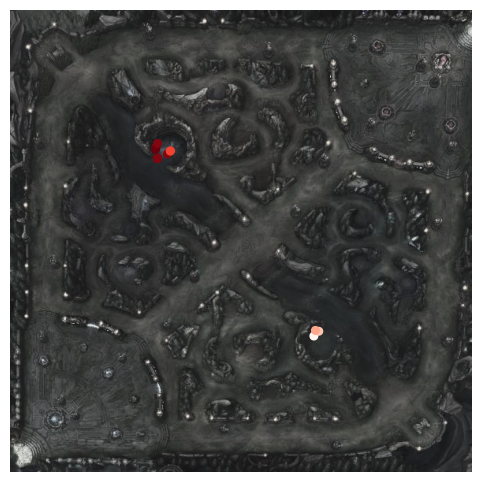

In [ ]:
death_spot(monster_log[monster_log['timestamp'] < 10 ])

* Í≤åÏûÑÎßàÎã§ ÌîåÎ†àÏù¥ ÏãúÍ∞ÑÏù¥ Îã§Î•¥Í∏∞ ÎïåÎ¨∏Ïóê ÌèâÍ∑†ÏùÑ ÎÇ¥Í∏∞ Ïï†Îß§ÌïòÎã§.
* Í∑∏ÎûòÎèÑ 15Î∂Ñ Ïù¥ÏÉÅ Í≤åÏûÑÏù¥Îãà, ÌôïÏã§ÌïúÍ±¥ 15Î∂Ñ Ïù¥Ï†Ñ Í≥®Îìú ÏÉÅÌô©ÏùÑ ÎπÑÍµêÌï† Ïàò ÏûàÎã§.

### *idea1. 15Î∂Ñ Ïù¥Ï†ÑÍπåÏßÄ Í≥®ÎìúÏ∞®Ïù¥Í∞Ä ÎÇòÎ©¥ ÏßÄÎäî Í±∏Íπå?*

ÌïúÌÉÄÎèÑ ÌïòÍ∏∞ Ï†ÑÏóê ÎùºÏù∏Ï†ÑÏù¥ ÌÑ∞ÏßÄÎ©¥ Í≥®ÎìúÏ∞®Ïù¥Í∞Ä ÎßéÏù¥ÎÇòÍ≤å ÎêòÏñ¥ ÏßÄÎäîÍ≤ΩÏö∞Í∞Ä ÎåÄÎ∂ÄÎ∂ÑÏûÑ..

* Ïö∞ÏôÅÍµ≥ÎãòÏù¥ Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Î•º Î∂ÑÏÑùÌï¥Î≥¥ÏïòÏäµÎãàÎã§. ÎùºÏù∏Ï†Ñ ÎèôÏïà 'Í∞Å ÎùºÏù∏Î≥Ñ' 1Î∂ÑÍ∞ÑÏùò Í≥®ÎìúÎ≥ÄÌôîÎüâÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Í∏âÍ≤©ÌïòÍ≤å Í≥®ÎìúÏ∞®Ïù¥Í∞Ä ÎÇú ÎùºÏù∏ÏùÄ Ïñ¥ÎîîÏùºÍπåÏöî? Î∞îÌÖÄÏ∞®Ïù¥ÏùºÍπåÏöî?

* Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Î•º Í∏∞Ï§ÄÏúºÎ°ú Î¥êÏïºÌï†Íπå? Ïù¥Í∏¥ Í≤ΩÍ∏∞Îäî Ïñ¥ÎñªÍ≤å?

In [ ]:
lose_match_list = champion_info[(champion_info['summonerName'] == summoner_name) & (champion_info['win']== False)]['matchId'].tolist()
lose_match_list

In [ ]:
lose_match_gold = gold_df[gold_df['matchId'].isin(lose_match_list)].groupby(['matchId','timestamp','win','teamPosition']).agg({'totalGold':'sum'}).reset_index()


NameError: name 'gold_df' is not defined

In [ ]:
lose_match_gold['timestamp'] = lose_match_gold['timestamp'].astype(int)

In [ ]:
# (15Î∂Ñ, ÎùºÏù∏Ï†Ñ ÎèôÏïà) Ìè¨ÏßÄÏÖòÎ≥Ñ Í≥®ÎìúÏ∞®Ïù¥
line_lose = lose_match_gold[(lose_match_gold['timestamp'] >= 0) & (lose_match_gold['timestamp'] < 16)].sort_values(by=['matchId','timestamp','win'], ascending=[True,True,False])
line_lose['totalGold_diff'] = line_lose.groupby(['matchId','timestamp','teamPosition'])['totalGold'].diff()

#(Í≤ΩÍ∏∞Í∞Ä ÎÅùÎÇòÍ≥†)Ìè¨ÏßÄÏÖòÎ≥Ñ Í≥®ÎìúÏ∞®Ïù¥
hanta_lose = lose_match_gold[lose_match_gold['timestamp'] >= 15].sort_values(by=['matchId','timestamp','win'], ascending=[True,True,False])
hanta_lose['totalGold_diff'] = hanta_lose.groupby(['matchId','timestamp','teamPosition'])['totalGold'].diff()
hanta_lose = hanta_lose.groupby('matchId').tail(5)

# line_lose[line_lose['win'] == False]

In [ ]:
# (Ïù¥Í∏¥ÌåÄ-ÏßÑÌåÄ) Í∞íÏù¥ - ÏùºÏàòÎ°ù Ï∞®Ïù¥Í∞Ä ÎßéÏù¥ÎÇú Ìè¨ÏßÄÏÖòÏù¥Îã§.
# line_lose_gold = line_lose.groupby(['matchId','teamPosition']).agg({'totalGold_diff':'sum'}).reset_index()  #(ÎàÑÏ†Å)
line_lose['rank'] = line_lose.groupby('matchId')['totalGold_diff'].rank(ascending=False, method='first')

# hanta_lose_gold = hanta_lose.groupby(['matchId','teamPosition']).agg({'totalGold_diff':'sum'}).reset_index()  #(ÎàÑÏ†Å)
hanta_lose['rank'] = hanta_lose.groupby('matchId')['totalGold_diff'].rank(ascending=False, method='first')


hanta_lose[hanta_lose['totalGold_diff'] < -2000]['teamPosition'].value_counts()

Series([], Name: teamPosition, dtype: int64)

In [ ]:
# most_common_ranks = t.groupby('teamPosition')['rank'].apply(lambda x: x.mode()[0]).reset_index()

# ÎùºÏù∏Ï†Ñ,ÌïúÌÉÄ Ìè¨ÏßÄÏÖòÎ≥Ñ ÌèâÍ∑† Í≥®ÎìúÏ∞®Ïù¥
avg_gold_by_position_line = line_lose.groupby(['teamPosition','timestamp'])['totalGold_diff'].mean().reset_index()
avg_gold_by_position_hanta = hanta_lose.groupby('teamPosition')['totalGold_diff'].mean().reset_index()

# ÎØ∏ÎìúÏ∞®Ïù¥Í∞Ä ÎÇ¨ÏßÄÎßå ÏßÑ Í≤ØÍ∏∞
hanta_lose[(hanta_lose['teamPosition'] == 'MIDDLE')&(hanta_lose['totalGold_diff']>0)] #['totalGold_diff'].mean()

In [ ]:
avg_gold_by_position_line

In [ ]:
df = avg_gold_by_position_line[avg_gold_by_position_line['teamPosition'] != '']
df['totalGold_diff'] = df['totalGold_diff'].astype(int)

result = []
for team in df['teamPosition'].unique():
    team_data = {
        'id': team,
        'data': []
    }

    team_df = df[df['teamPosition'] == team]
    for index, row in team_df.iterrows():
        item = {
            'x': row["timestamp"],
            'y': row["totalGold_diff"]
        }
        team_data["data"].append(item)

    result.append(team_data)

result

# ÎìÄÏò§ Ïä§ÏΩîÏñ¥

* ÏôÅÍµ≥ÎãòÍ≥º ÎåÄÌëúÏ†ÅÏúºÎ°ú Í∞ôÏù¥ Í≤åÏûÑÏùÑ Ìïú Î©§Î≤ÑÏùò Ïä§ÏΩîÏñ¥Î•º Íµ¨Ìï¥Î≥¥Ïûê
* ÌòÑÏû¨ÍπåÏßÄÏùò ÏäπÎ•†
* Î™®Ïä§Ìä∏ ÎùºÏù¥ÎÑàÏùò Í∏∞Î≥∏Ï†ÅÏù∏ ÏßÄÌëú(Ï†ïÍ∏ÄÏù¥Î©¥ ÏÉÅÎåÄÏ†ïÍ∏ÄÍ≥º ÎπÑÍµê)
* Í∏∞Ïó¨ÎèÑ : Ïö∞ÏôÅÍµ≥ÎãòÏùò ÌÇ¨Ïóê Ïñ¥ÎäêÏ†ïÎèÑ ÎèÑÏõÄÏùÑ Ï£ºÏóàÎäîÏßÄ

In [ ]:
match_info['summonerName']

In [ ]:
# Ïö∞ÏôÅÍµ≥ == ÎèàÍπåÏä§ # The Nollan #

match_info['jungling'] = match_info['dragonTakedowns'] + match_info['baronTakedowns'] + match_info['enemyJungleMonsterKills']

In [ ]:
# ÎÜÄÎûÄ,Ï≤úÏñë Îß§Ïπò
nollan_match = match_info[match_info['summonerName'] == 'The Nollan']['matchId'].tolist()
chun_match = match_info[match_info['summonerName'] =='ÎèàÍπåÏä§']['matchId'].tolist()


In [ ]:
# ÏúÑ Ìï¥ÎãπÌïòÎäî Îß§ÏπòÎßå Í∞ÄÏ†∏ÏôÄÏÑú ÏßëÍ≥ÑÌïòÎ©¥ Îê®

nol_match_info = match_info[match_info['matchId'].isin(nollan_match)]
chun_match_info = match_info[match_info['matchId'].isin(chun_match)]


In [ ]:
# Ï≤úÏñë Ìè¨ÏßÄÏÖò Ï†ï
match_info[match_info['summonerName'] =='ÎèàÍπåÏä§']['teamPosition'].value_counts() #

JUNGLE     17
UTILITY     5
TOP         1
Name: teamPosition, dtype: int64

In [ ]:
# ÎÜÄÎûÄÎãòÏùò ÎìÄÏò§ Ï£º Ìè¨ÏßÄÏÖòÏùÄ jungle ÏûÖÎãàÎã§.

# ÏßÄÍ∏àÍπåÏßÄ ÎßåÎÇú ÏÉÅÎåÄÏ†ïÍ∏ÄÍ≥º ÎπÑÍµêÎ•º Ìï¥Î¥ÖÏãúÎã§.
# Ï†ïÍ∏ÄÏóê Ï§ëÏöîÌïú ÏßÄÌëúÎ•º ÏúÑÏ£ºÎ°ú!

# Ï†ÑÏ≤¥Ï†ÅÏù∏ Ï∞∏Ïó¨ÎèÑ Radar chart
def radar_chart(match_info,summoner_name,position):

    summoner_match_info = match_info[(match_info['summonerName'] == summoner_name) & (match_info['teamPosition'] == position)]
    matchids = summoner_match_info['matchId'].tolist()
    other_line_info = match_info[(match_info['summonerName'] != summoner_name) & (match_info['matchId'].isin(matchids)) &(match_info['teamPosition'] == position)]

    # ÏôÅÍµ≥ÎãòÏùò ÎåÄÌëú Í≤åÏûÑÏßÄÌëú (ÌèâÍ∑†)
    wak_score = summoner_match_info[['summonerName','visionScore','jungling','jungleCsBefore10Minutes',
                        'totalDamageDealtToChampions','damageDealtToBuildings']]
    opponent_score = other_line_info[['summonerName','visionScore','jungling','jungleCsBefore10Minutes',
                            'totalDamageDealtToChampions','damageDealtToBuildings']]

    wak_vs_df = pd.concat([wak_score,opponent_score])
    wak_vs_df.loc[wak_vs_df['summonerName']!= summoner_name, 'summonerName'] = 'ÏÉÅÎåÄÎùºÏù¥ÎÑà'


    normalization_df = (wak_vs_df - wak_vs_df.min(numeric_only=True))/(wak_vs_df.max(numeric_only=True) - wak_vs_df.min(numeric_only=True))
    normalization_df['summonerName'] = wak_vs_df['summonerName']

    z = normalization_df.groupby(['summonerName']).agg(
        totalDamageDealtToChampions= pd.NamedAgg(column = 'totalDamageDealtToChampions', aggfunc='mean'),
        jungleCsBefore10Minutes = pd.NamedAgg(column = 'jungleCsBefore10Minutes', aggfunc='mean'),
        jungling = pd.NamedAgg(column = 'jungling', aggfunc='mean'),
        visionScore = pd.NamedAgg(column = 'visionScore', aggfunc='mean'),
        damageDealtToBuildings = pd.NamedAgg(column = 'damageDealtToBuildings', aggfunc='mean'),
    ).reset_index()

    z.columns =['summonerName','Ï±îÌîºÏñ∏ÎîúÎüâ','10Î∂ÑCS','Ï†ïÍ∏ÄÎßÅ',
                        'ÏãúÏïºÏ†êÏàò','ÌÉÄÏõåÌîºÌï¥Îüâ']

    melted_df = pd.melt(z, id_vars=["summonerName"], var_name="var", value_name="value")
    pivoted_df = melted_df.pivot(index="var", columns="summonerName", values="value").reset_index()
    radar_data = pivoted_df.to_dict("records")


    return radar_data, opponent_score, wak_score, normalization_df



nol_radar, opponent_score, nol_score, nz = radar_chart(nol_match_info,'The Nollan','JUNGLE')
chun_radar, chopponent_score, chun_score , cz= radar_chart(match_info,'ÎèàÍπåÏä§','JUNGLE')




In [ ]:
chun_radar

[{'var': '10Î∂ÑCS', 'ÎèàÍπåÏä§': 0.672807018218746, 'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.5997076025921203},
 {'var': 'ÏãúÏïºÏ†êÏàò', 'ÎèàÍπåÏä§': 0.4791666666666667, 'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.4409722222222222},
 {'var': 'Ï†ïÍ∏ÄÎßÅ', 'ÎèàÍπåÏä§': 0.1884920634920635, 'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.30952380952380953},
 {'var': 'Ï±îÌîºÏñ∏ÎîúÎüâ', 'ÎèàÍπåÏä§': 0.45544698107321885, 'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.3684531884383894},
 {'var': 'ÌÉÄÏõåÌîºÌï¥Îüâ', 'ÎèàÍπåÏä§': 0.26145464373604177, 'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.21557205650151495}]

In [ ]:
# ÎÜÄÎûÄ,Ï≤úÏñë ÏäπÌå®

print(nol_match_info[nol_match_info['summonerName'] == 'The Nollan']['win'].value_counts())
print(chun_match_info[(chun_match_info['summonerName'] == 'Ïö∞ÏôÅÍµ≥') | (chun_match_info['summonerName'] == 'ÎèàÍπåÏä§')]['win'].value_counts())

True     14
False     9
Name: win, dtype: int64


In [ ]:
# Ï†ÑÏ≤¥ Í≤ΩÍ∏∞ ÎÜÄÎûÄ Í∏∞Ïó¨ÎèÑ
info.columns=['matchId','teamId','killerId','summonerName','championName','killerPosition','win']
kill_assist = pd.merge(kill_log, info, on=['matchId','killerId'], how='inner')
wak_kill_log = kill_assist[kill_assist['summonerName'] == summoner_name]

In [ ]:
def replace_ids_with_names(ids, match_id):
    if isinstance(ids, list):
        return [info.loc[(info['killerId'] == id) & (info['matchId'] == match_id), 'summonerName'].values[0] if pd.notna(id) else None for id in ids]
    else:
        return None


# wak_kill_log['assistingParticipantIds'] = wak_kill_log.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)
kill_assist['assistingParticipantIds'] = kill_assist.apply(lambda row: replace_ids_with_names(row['assistingParticipantIds'], row['matchId']), axis=1)


In [ ]:
# ÎìÄÏò§Î•º ÏßÑÌñâÌïú Îß§ÏπòÍ≤ΩÍ∏∞ Ï§ëÏóêÏÑú
# ÎÜÄÎûÄÍ≥º ÏÉÅÌò∏ÏûëÏö©ÌïòÏó¨ ÌÇ¨Ìïú Î°úÍ∑∏ (Ïö∞ÏôÅÍµ≥, ÎÜÄÎûÄ ÌÇ¨)
nol_kill_log = kill_assist[(kill_assist['matchId'].isin(nollan_match)) & (kill_assist['summonerName'] == summoner_name) | (kill_assist['summonerName'] == 'The Nollan')]

# Ï≤úÏñëÍ≥º ÏÉÅÌò∏ÏûëÏö©ÌïòÏó¨ ÌÇ¨Ìïú Î°úÍ∑∏ (Ïö∞ÏôÅÍµ≥, Ï≤úÏñë ÌÇ¨)
chun_kill_log = kill_assist[(kill_assist['matchId'].isin(chun_match)) & (kill_assist['summonerName'] == summoner_name) | (kill_assist['summonerName'] == 'ÎèàÍπåÏä§')]





In [ ]:
nol_assist = nol_kill_log[nol_kill_log['assistingParticipantIds'].apply(lambda ids: 'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥' in ids if isinstance(ids, list) else False or 'The Nollan' in ids if isinstance(ids, list) else False)]
chun_assist = chun_kill_log[chun_kill_log['assistingParticipantIds'].apply(lambda ids: 'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥' in ids if isinstance(ids, list) else False or 'The Nollan' in ids if isinstance(ids, list) else False)]


In [ ]:
nol_assist

In [ ]:
# ÏûêÏÑ∏Ìïú Îç∞ÎØ∏ÏßÄ
nol_damage_log = damage(nol_kill_log)
nol_damage_log

# ÏôÄÎìúÏôÄ Í¥ÄÎ†®ÌïòÏó¨..


* ÏÜåÌôòÏÇ¨Í∞Ä Ï£ΩÍ∏∞Ï†ÑÏóê ÏôÄÎìúÎ•º Î∞ïÍ≥† Ï£ΩÏóàÎäîÏßÄ ÌôïÏù∏Ìï¥Î≥¥Ïûê
* 15Î∂ÑÏù¥Ï†ÑÍ≥º 15Î∂Ñ Ïù¥ÌõÑÎ•º Í∏∞Ï†êÏúºÎ°ú ÏôÄÎìúÎ•º Î∞ïÎäî ÌöüÏàòÏùò Ï∞®Ïù¥Í∞Ä ÏûàÎã§Î©¥ ÏôÄÎìúÎ•º Ïûò Î∞ïÏßÄ ÏïäÏùÄ Íµ¨Í∞ÑÏóê deathÍ∞Ä Îçî ÎßéÏùÑÍπå?


In [ ]:
ward_kill_15 = all_log[(all_log['type'] == 'WARD_KILL') & (all_log['timestamp'] <16)]

In [ ]:
# Ï£ΩÏùÄ Ï¢åÌëú
wakteam_death_log.loc[:, 'lane'] = wakteam_death_log.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)


In [ ]:
# ward Ïóê ÎåÄÌïú log champion_info ÏôÄ Í≤∞Ìï©
ward_info = champion_info[['matchId','teamPosition','participantId','summonerName','win']]
ward_info.columns = ['matchId','teamPosition','creatorId','summonerName','win']
ward_log = pd.merge(kill_log, ward_info, on=['matchId','creatorId'],how='inner')
summoner_ward_log = ward_log[ward_log['summonerName'] == summoner_name][['matchId','timestamp','position','type','wardType','creatorId','killerId','victimId','summonerName','win']]


In [ ]:
def ward_death(summoner_name, wakteam_death_log ,summoner_ward_log, champion_info, timestamp):
  # 15Î∂Ñ Ï†ÑÌõÑ Îç∞Ïä§Î°úÍ∑∏
  wak_death = wakteam_death_log[wakteam_death_log['victimSummoner'] == summoner_name]

  if timestamp == '15Î∂ÑÏ†Ñ':
      wak_death = wak_death[wak_death['timestamp'] < 16]

      ward_static = summoner_ward_log[summoner_ward_log['timestamp'] < 16].groupby(['matchId','win']).agg(
          ward_cnt = pd.NamedAgg(column='wardType', aggfunc='count')
      ).reset_index()

      # nÎ∂Ñ  Îç∞Ïä§ÏßëÍ≥Ñ
      death_static = wak_death.groupby(['matchId']).agg(
        death_cnt = pd.NamedAgg(column='victimId',aggfunc='count')
      ).reset_index()


  elif timestamp == '15Î∂ÑÏù¥ÌõÑ':
      wak_death = wak_death[wak_death['timestamp'] > 15]
      ward_static = summoner_ward_log[summoner_ward_log['timestamp'] > 15].groupby(['matchId','win']).agg(
          ward_cnt = pd.NamedAgg(column='wardType', aggfunc='count')
      ).reset_index()

      # nÎ∂Ñ  Îç∞Ïä§ÏßëÍ≥Ñ
      death_static = wak_death.groupby(['matchId']).agg(
        death_cnt = pd.NamedAgg(column='victimId',aggfunc='count')
      ).reset_index()


  ward_death = pd.merge(ward_static, death_static , on=['matchId'],how= 'outer')
  ward_death['death_cnt'] = ward_death['death_cnt'].fillna(0).astype(int)

  return ward_death

In [ ]:
ward_death_15 = ward_death(summoner_name, wakteam_death_log , summoner_ward_log, champion_info, '15Î∂ÑÏ†Ñ')
ward_death_16 = ward_death(summoner_name, wakteam_death_log , summoner_ward_log, champion_info, '15Î∂ÑÏù¥ÌõÑ')

In [ ]:
# ÏÜåÌôòÏÇ¨Í∞Ä ÎùºÏù∏Ï†Ñ ÎèôÏïà Ï†ïÍ∏ÄÍ∞±Ïóê ÏùòÌï¥ÏÑú Ï£ΩÏùÄ Í≤ΩÏö∞
# ÏôÄÎìúÎ•º Î∞ïÏïòÏùÑÍπå!!!!!!!!!!!!!!?

wak_all_death = wakteam_death_log[(wakteam_death_log['victimSummoner'] == summoner_name) & (wakteam_death_log['timestamp'] < 16 )]
wak_death_gang = wak_all_death[(wak_all_death['killerId'] == 'JUNGLE') | (wak_all_death['assistingParticipantIds'].apply(lambda x: ('JUNGLE' in x) or ('TOP' in x) if isinstance(x, list) else False))]
wak_death_gang = wak_death_gang[['matchId','timestamp','type','wardType','position','assistingParticipantIds','victimSummoner','victimPosition','killerPosition','lane']]


static = wak_death_gang.groupby(['matchId']).agg(
    by_jungle_death = pd.NamedAgg(column='type', aggfunc='count')
)
static


by_jungle_death
matchId                       
KR_6907021547                1
KR_6909622124                2
KR_6909716665                1
KR_6909895917                1
KR_6911073913                1
KR_6911257292                1
KR_6912889593                1
KR_6915767550                1
KR_6918641204                1
KR_6919998269                1
KR_6922216547                1
KR_6925927172                2

In [ ]:
df = wak_death_gang[wak_death_gang['victimPosition'] == wak_death_gang['lane']]
df2 = summoner_ward_log[(summoner_ward_log['timestamp'] < 16) & (summoner_ward_log['matchId'].isin(df['matchId'].tolist()))]
df3 = ward_kill_15[ward_kill_15['matchId'].isin(df['matchId'].tolist())]

result = pd.concat([df,df2,df3], axis = 0).sort_values(by=['matchId','timestamp'], ascending=[True,True])

result[['matchId','timestamp','type','wardType','position','assistingParticipantIds','victimteam','victimSummoner','victimPosition','killerSummoner','killerteam','killerChampion','killerPosition','summonerName','lane']]

In [ ]:
# kill Ïóê ÎåÄÌïú Ï†ÑÏ≤¥ Î°úÍ∑∏
champion_info['victimId'] = champion_info['participantId']
champion_info['killerId'] = champion_info['participantId']
champion_info['creatorId'] = champion_info['participantId']

col = ['timestamp','type','wardType','position','killerId','victimId_x',
      'assistingParticipantIds','victimDamageDealt','victimDamageReceived',
      'matchId','teamId_y','summonerName','championName','teamPosition','win']

df = pd.merge(kill_log, champion_info , on = ['matchId','killerId'], how = 'inner')[col]
df.rename(columns={'victimId_x': 'victimId','teamId_y':'teamId','teamPosition':'killerPosition','summonerName':'killerSummoner'}, inplace=True)

df = pd.merge(df,champion_info, on = ['matchId','victimId'], how = 'left')[['timestamp','matchId','type','wardType','position','killerId_x','victimId','assistingParticipantIds',
                                                                                'victimDamageDealt','victimDamageReceived','teamId_x','killerSummoner','championName_x','killerPosition',
                                                                                'summonerName',	'championName_y',	'teamPosition',	'win_y'	,'killerId_y',	'creatorId']]
df.rename(columns={'killerId_x': 'killerId','teamId_x':'killerteam','championName_x':'killerChampion','championName_y':'victimChampion','summonerName':'victimSummoner','teamPosition':'victimPosition'}, inplace=True)


df.drop(['win_y','killerId_y','creatorId'], axis=1, inplace=True)
